In [1]:
# ==========================
# Pirate Pain Prediction: LSTM / GRU / Transformer / CNN1D / MLP / GNN / Ensemble Models / TCN / TimesNet / BNN 
# ==========================

import json
import os
import time
import random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, PowerTransformer
from scipy.ndimage import gaussian_filter1d
import torch_geometric.nn as pyg_nn
import torch_geometric.utils as pyg_utils
from torch_geometric.data import Data
from torch_geometric.nn import GATConv, GCNConv
from torch_geometric.utils import dense_to_sparse
from scipy.stats import linregress
from scipy.fft import rfft, rfftfreq
import pickle
from scipy.ndimage import uniform_filter1d
from sklearn.model_selection import GroupKFold
from sklearn.utils.class_weight import compute_class_weight

# --------------------------
# CONFIG & SEEDS
# --------------------------
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --------------------------
# DIRECTORIES
# --------------------------
DATA_DIR = "dataset"
PRED_DIR = "prediction"
MODELS_DIR = "models"
os.makedirs(PRED_DIR, exist_ok=True)
os.makedirs(MODELS_DIR, exist_ok=True)
timestamp = time.strftime("%Y%m%d-%H%M%S")
PLOTS_DIR = os.path.join(MODELS_DIR, timestamp, "plots")
os.makedirs(PLOTS_DIR, exist_ok=True)
CHECKPOINT_DIR = os.path.join(MODELS_DIR, timestamp, "checkpoints")
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

# --------------------------
# HYPERPARAMETERS
# --------------------------
MODEL_TYPE = "MLP"  # options: LSTM / GRU / Transformer / CNN1D / MLP / Ensemble / GNN / TCN / TimesNet / BNN
BATCH_SIZE = 64
NUM_EPOCHS = 100
LR = 1e-3
VALID_SPLIT = 0.2
EARLY_STOPPING_PATIENCE = 30
PREPROCESSING_VISUAL_CHECK = False
K_FOLDS = 4

PREPROCESSING_OPTS = {
    "gaussian": "none",   # "gaussian", "min", "min+log", "min+asinh", "boxcox", "none"
    "exp": "min+asinh",
    "pain": "none"
}

SCALER_OPTS = {
    "gaussian": "standard",   # "standard", "minmax", "robust", "none"
    "exp": "standard",
    "pain": "none"
}

epsilon = 1e-6

AUGMENTATION_OPTS = {
    "jitter": False, # jitter: adds Gaussian noise
    "jitter_sigma": 0.01,       

    "scaling": False, # scaling: scales the signal
    "scaling_sigma": 0.05,       

    "time_warp": False, # time warping: random time distortions
    "time_warp_max": 0.05,       

    "random_mask": True, # random masking: masks random sections
    "mask_max_ratio": 0.05,      

    "aug_prob": 0.3,          # 0.0 to disable augmentation
    "n_augmented": 1          # 0 to disable augmentation  
}

LOAD_DATASET = False  
ADD_FEATURES = False   

# --------------------------
# DATA LOADING
# --------------------------
X_train = pd.read_csv(os.path.join(DATA_DIR, "pirate_pain_train.csv"))
y_train = pd.read_csv(os.path.join(DATA_DIR, "pirate_pain_train_labels.csv"))
X_test = pd.read_csv(os.path.join(DATA_DIR, "pirate_pain_test.csv"))

categorical_cols = ['n_legs', 'n_hands', 'n_eyes']
X_train_enc = pd.get_dummies(X_train, columns=categorical_cols)
X_test_enc = pd.get_dummies(X_test, columns=categorical_cols)
X_test_enc = X_test_enc.reindex(columns=X_train_enc.columns, fill_value=0)

# Drop constant column
for c in ['joint_30']:
    if c in X_train_enc.columns:
        X_train_enc.drop(columns=[c], inplace=True)
        X_test_enc.drop(columns=[c], inplace=True)

# Divide based on feature distribution types
pain_cols = [f"pain_survey_{i}" for i in range(1, 5)]
gaussian_joints = [f"joint_{i:02d}" for i in range(0, 13)] + [f"joint_{i}" for i in range(26, 30)]
exp_joints = [f"joint_{i}" for i in range(13, 26)]
onehot_cols = [c for c in X_train_enc.columns if any(k in c for k in ['n_legs_', 'n_hands_', 'n_eyes_'])]
other_cols = ["time"]

# --------------------------
# PREPROCESSING
# --------------------------

def apply_preprocessing(X_train, X_test, cols, option):
    """Apply preprocessing per group."""
    X_train_mod, X_test_mod = X_train.copy(), X_test.copy()

    for col in cols:
        if col not in X_train_mod.columns:
            continue

        x_train, x_test = X_train_mod[col].values, X_test_mod[col].values
        min_val = min(x_train.min(), x_test.min())
        x_train_shift = x_train - min_val + epsilon
        x_test_shift = x_test - min_val + epsilon

        # --- apply chosen preprocessing ---
        if option == "gaussian":
            X_train_mod[col] = gaussian_filter1d(x_train, sigma=1)
            X_test_mod[col] = gaussian_filter1d(x_test, sigma=1)
            
        if option == "min":
            X_train_mod[col] = x_train_shift
            X_test_mod[col] = x_test_shift

        elif option == "min+log":
            X_train_mod[col] = np.log(x_train_shift)
            X_test_mod[col] = np.log(x_test_shift)

        elif option == "min+asinh":
            X_train_mod[col] = np.arcsinh(x_train_shift)
            X_test_mod[col] = np.arcsinh(x_test_shift)

        elif option == "boxcox":
            pt = PowerTransformer(method='box-cox', standardize=False)
            X_train_mod[col] = pt.fit_transform(x_train_shift.reshape(-1, 1)).ravel()
            X_test_mod[col] = pt.transform(x_test_shift.reshape(-1, 1)).ravel()

        elif option == "none":
            pass  # leave as is

        else:
            raise ValueError(f"Unknown preprocessing option: {option}")

    return X_train_mod, X_test_mod


def apply_scaler(X_train, X_test, cols, option):
    if len(cols) == 0 or option == "none":
        return X_train, X_test

    if option == "standard":
        scaler = StandardScaler()
    elif option == "minmax":
        scaler = MinMaxScaler()
    elif option == "robust":
        scaler = RobustScaler()
    else:
        raise ValueError(f"Unknown scaler: {option}")

    X_train[cols] = scaler.fit_transform(X_train[cols])
    X_test[cols] = scaler.transform(X_test[cols])

    return X_train, X_test


# lag analysis (autocorrelation)
from statsmodels.tsa.stattools import acf

def top3_acf_lags(df, feature_cols, sample_id=0, sample_idx_col='sample_index', 
                  time_col='time', max_lag=200, rolling_window=None, filter_size=3, plot=True):
    seq = df[df[sample_idx_col] == sample_id].sort_values(time_col)
    results = []
    for feature in feature_cols:
        y = seq[feature].values
        if rolling_window is not None:
            y = pd.Series(y).rolling(rolling_window, min_periods=1, center=True).mean().values
        y_filtered = uniform_filter1d(y, size=filter_size)
        nlags = min(max_lag, len(y_filtered)-2)
        acf_vals = acf(y_filtered, fft=False, nlags=nlags)
        min_lag = rolling_window if rolling_window is not None else 1
        top3_idx = np.argsort(acf_vals[min_lag:])[::-1][:3] + min_lag
        top3_vals = acf_vals[top3_idx]

        for lag, val in zip(top3_idx, top3_vals):
            results.append({
                "feature": feature,
                "lag": lag,
                "acf_value": val
            })

        if plot:
            plt.figure(figsize=(8,4))
            markerline, stemlines, baseline = plt.stem(range(nlags+1), acf_vals)
            plt.setp(markerline, 'markerfacecolor', 'blue')
            plt.setp(stemlines, 'color', 'blue')
            plt.axvline(min_lag, color='red', linestyle='--', label=f'Min Lag = {min_lag}')

            plt.stem(top3_idx, top3_vals, linefmt='orange', markerfmt='D', basefmt=" ")

            plt.xlabel("Lag")
            plt.ylabel("Autocorrelation")
            plt.title(f"ACF - Feature: {feature} (Filtered)")
            plt.legend()
            plt.show()

    df_top3 = pd.DataFrame(results)
    return df_top3


def analyze_lags(df, feature_cols, sample_ids=None, **kwargs):
    if sample_ids is None:
        sample_ids = [0]

    all_results = []
    for sid in sample_ids:
        df_top3 = top3_acf_lags(df, feature_cols, sample_id=sid, **kwargs)
        df_top3['sample_id'] = sid
        all_results.append(df_top3)

    return pd.concat(all_results, ignore_index=True)

if PREPROCESSING_VISUAL_CHECK:
    print("\n--- ACF Analysis Before Preprocessing ---")
    top3_acf_table = top3_acf_lags(X_train_enc, gaussian_joints + exp_joints, sample_id=0, rolling_window=10, max_lag=160)
    for feature, group in top3_acf_table.groupby('feature'):
        print(f"\nFeature: {feature}")
        top3 = group.sort_values('acf_value', ascending=False)
        for i, row in top3.iterrows():
            print(f"  Lag: {row['lag']}, ACF: {row['acf_value']:.4f}")
    


--- Feature Engineering Pipeline ---
Using raw preprocessed dataset (no feature engineering).
Total feature columns: 40
Final preprocessing summary:
Pain cols: ['pain_survey_1', 'pain_survey_2', 'pain_survey_3', 'pain_survey_4']
Gaussian joints: ['joint_00', 'joint_01', 'joint_02', 'joint_03', 'joint_04', 'joint_05', 'joint_06', 'joint_07', 'joint_08', 'joint_09', 'joint_10', 'joint_11', 'joint_12', 'joint_26', 'joint_27', 'joint_28', 'joint_29']
Exponential joints: ['joint_13', 'joint_14', 'joint_15', 'joint_16', 'joint_17', 'joint_18', 'joint_19', 'joint_20', 'joint_21', 'joint_22', 'joint_23', 'joint_24', 'joint_25']
One-hot cols: ['n_legs_one+peg_leg', 'n_legs_two', 'n_hands_one+hook_hand', 'n_hands_two', 'n_eyes_one+eye_patch', 'n_eyes_two']
Preprocessing: {'gaussian': 'none', 'exp': 'min+asinh', 'pain': 'none'}
Scalers: {'gaussian': 'standard', 'exp': 'standard', 'pain': 'none'}
Final feature columns (40): ['pain_survey_1', 'pain_survey_2', 'pain_survey_3', 'pain_survey_4', 'joi

Fold 1 Epoch 1 Training: 100%|██████████| 16/16 [00:00<00:00, 55.42it/s]


Epoch 1 | Train Loss: 0.9907 | Val Loss: 0.8387 | Acc: 0.8485 | Precision: 0.7797 | Recall: 0.5174 | F1: 0.5753 | LR: 0.000976


Fold 1 Epoch 2 Training: 100%|██████████| 16/16 [00:00<00:00, 181.02it/s]


Epoch 2 | Train Loss: 0.7239 | Val Loss: 0.6423 | Acc: 0.8364 | Precision: 0.7533 | Recall: 0.5308 | F1: 0.5516 | LR: 0.000905


Fold 1 Epoch 3 Training: 100%|██████████| 16/16 [00:00<00:00, 169.78it/s]


Epoch 3 | Train Loss: 0.6177 | Val Loss: 0.5624 | Acc: 0.8545 | Precision: 0.7467 | Recall: 0.5615 | F1: 0.6168 | LR: 0.000796


Fold 1 Epoch 4 Training: 100%|██████████| 16/16 [00:00<00:00, 120.05it/s]


Epoch 4 | Train Loss: 0.5684 | Val Loss: 0.5109 | Acc: 0.8848 | Precision: 0.7470 | Recall: 0.6282 | F1: 0.6724 | LR: 0.000658


Fold 1 Epoch 5 Training: 100%|██████████| 16/16 [00:00<00:00, 163.18it/s]


Epoch 5 | Train Loss: 0.5350 | Val Loss: 0.4882 | Acc: 0.8970 | Precision: 0.7679 | Recall: 0.6441 | F1: 0.6904 | LR: 0.000505


Fold 1 Epoch 6 Training: 100%|██████████| 16/16 [00:00<00:00, 161.38it/s]


Epoch 6 | Train Loss: 0.5344 | Val Loss: 0.4718 | Acc: 0.9030 | Precision: 0.8032 | Recall: 0.6574 | F1: 0.7083 | LR: 0.000352


Fold 1 Epoch 7 Training: 100%|██████████| 16/16 [00:00<00:00, 184.14it/s]


Epoch 7 | Train Loss: 0.5001 | Val Loss: 0.4582 | Acc: 0.9030 | Precision: 0.8092 | Recall: 0.6774 | F1: 0.7282 | LR: 0.000214


Fold 1 Epoch 8 Training: 100%|██████████| 16/16 [00:00<00:00, 181.51it/s]


Epoch 8 | Train Loss: 0.4941 | Val Loss: 0.4522 | Acc: 0.9273 | Precision: 0.8935 | Recall: 0.7308 | F1: 0.7873 | LR: 0.000105


Fold 1 Epoch 9 Training: 100%|██████████| 16/16 [00:00<00:00, 183.80it/s]


Epoch 9 | Train Loss: 0.5059 | Val Loss: 0.4522 | Acc: 0.9273 | Precision: 0.8935 | Recall: 0.7308 | F1: 0.7873 | LR: 0.000034


Fold 1 Epoch 10 Training: 100%|██████████| 16/16 [00:00<00:00, 173.28it/s]


Epoch 10 | Train Loss: 0.4846 | Val Loss: 0.4503 | Acc: 0.9212 | Precision: 0.8905 | Recall: 0.7174 | F1: 0.7778 | LR: 0.001000


Fold 1 Epoch 11 Training: 100%|██████████| 16/16 [00:00<00:00, 172.62it/s]


Epoch 11 | Train Loss: 0.4786 | Val Loss: 0.4333 | Acc: 0.9394 | Precision: 0.8994 | Recall: 0.7882 | F1: 0.8297 | LR: 0.000994


Fold 1 Epoch 12 Training: 100%|██████████| 16/16 [00:00<00:00, 169.50it/s]


Epoch 12 | Train Loss: 0.4739 | Val Loss: 0.4274 | Acc: 0.9394 | Precision: 0.9098 | Recall: 0.7774 | F1: 0.8283 | LR: 0.000976


Fold 1 Epoch 13 Training: 100%|██████████| 16/16 [00:00<00:00, 166.51it/s]


Epoch 13 | Train Loss: 0.4656 | Val Loss: 0.4255 | Acc: 0.9394 | Precision: 0.9098 | Recall: 0.7774 | F1: 0.8283 | LR: 0.000946


Fold 1 Epoch 14 Training: 100%|██████████| 16/16 [00:00<00:00, 207.86it/s]


Epoch 14 | Train Loss: 0.4421 | Val Loss: 0.4178 | Acc: 0.9273 | Precision: 0.8549 | Recall: 0.7615 | F1: 0.8006 | LR: 0.000905


Fold 1 Epoch 15 Training: 100%|██████████| 16/16 [00:00<00:00, 182.63it/s]


Epoch 15 | Train Loss: 0.4276 | Val Loss: 0.4128 | Acc: 0.9394 | Precision: 0.8994 | Recall: 0.7882 | F1: 0.8297 | LR: 0.000855


Fold 1 Epoch 16 Training: 100%|██████████| 16/16 [00:00<00:00, 201.35it/s]


Epoch 16 | Train Loss: 0.4251 | Val Loss: 0.4059 | Acc: 0.9333 | Precision: 0.8700 | Recall: 0.7749 | F1: 0.8148 | LR: 0.000796


Fold 1 Epoch 17 Training: 100%|██████████| 16/16 [00:00<00:00, 188.29it/s]


Epoch 17 | Train Loss: 0.4259 | Val Loss: 0.3998 | Acc: 0.9333 | Precision: 0.8596 | Recall: 0.7856 | F1: 0.8161 | LR: 0.000730


Fold 1 Epoch 18 Training: 100%|██████████| 16/16 [00:00<00:00, 183.47it/s]


Epoch 18 | Train Loss: 0.4201 | Val Loss: 0.3971 | Acc: 0.9394 | Precision: 0.8730 | Recall: 0.7882 | F1: 0.8236 | LR: 0.000658


Fold 1 Epoch 19 Training: 100%|██████████| 16/16 [00:00<00:00, 183.09it/s]


Epoch 19 | Train Loss: 0.4114 | Val Loss: 0.3926 | Acc: 0.9394 | Precision: 0.8884 | Recall: 0.7574 | F1: 0.8004 | LR: 0.000582


Fold 1 Epoch 20 Training: 100%|██████████| 16/16 [00:00<00:00, 181.56it/s]


Epoch 20 | Train Loss: 0.3965 | Val Loss: 0.3907 | Acc: 0.9455 | Precision: 0.9128 | Recall: 0.7908 | F1: 0.8372 | LR: 0.000505


Fold 1 Epoch 21 Training: 100%|██████████| 16/16 [00:00<00:00, 182.56it/s]


Epoch 21 | Train Loss: 0.4001 | Val Loss: 0.3901 | Acc: 0.9394 | Precision: 0.8994 | Recall: 0.7882 | F1: 0.8297 | LR: 0.000428


Fold 1 Epoch 22 Training: 100%|██████████| 16/16 [00:00<00:00, 198.16it/s]


Epoch 22 | Train Loss: 0.4014 | Val Loss: 0.3901 | Acc: 0.9394 | Precision: 0.8994 | Recall: 0.7882 | F1: 0.8297 | LR: 0.000352


Fold 1 Epoch 23 Training: 100%|██████████| 16/16 [00:00<00:00, 176.01it/s]


Epoch 23 | Train Loss: 0.4002 | Val Loss: 0.3887 | Acc: 0.9394 | Precision: 0.8994 | Recall: 0.7882 | F1: 0.8297 | LR: 0.000280


Fold 1 Epoch 24 Training: 100%|██████████| 16/16 [00:00<00:00, 175.69it/s]


Epoch 24 | Train Loss: 0.3930 | Val Loss: 0.3858 | Acc: 0.9394 | Precision: 0.8994 | Recall: 0.7882 | F1: 0.8297 | LR: 0.000214


Fold 1 Epoch 25 Training: 100%|██████████| 16/16 [00:00<00:00, 180.60it/s]


Epoch 25 | Train Loss: 0.3927 | Val Loss: 0.3866 | Acc: 0.9394 | Precision: 0.8994 | Recall: 0.7882 | F1: 0.8297 | LR: 0.000155


Fold 1 Epoch 26 Training: 100%|██████████| 16/16 [00:00<00:00, 180.01it/s]


Epoch 26 | Train Loss: 0.3894 | Val Loss: 0.3873 | Acc: 0.9394 | Precision: 0.8994 | Recall: 0.7882 | F1: 0.8297 | LR: 0.000105


Fold 1 Epoch 27 Training: 100%|██████████| 16/16 [00:00<00:00, 173.34it/s]


Epoch 27 | Train Loss: 0.3963 | Val Loss: 0.3863 | Acc: 0.9394 | Precision: 0.8994 | Recall: 0.7882 | F1: 0.8297 | LR: 0.000064


Fold 1 Epoch 28 Training: 100%|██████████| 16/16 [00:00<00:00, 141.47it/s]


Epoch 28 | Train Loss: 0.3887 | Val Loss: 0.3877 | Acc: 0.9394 | Precision: 0.8994 | Recall: 0.7882 | F1: 0.8297 | LR: 0.000034


Fold 1 Epoch 29 Training: 100%|██████████| 16/16 [00:00<00:00, 190.45it/s]


Epoch 29 | Train Loss: 0.3855 | Val Loss: 0.3880 | Acc: 0.9394 | Precision: 0.8994 | Recall: 0.7882 | F1: 0.8297 | LR: 0.000016


Fold 1 Epoch 30 Training: 100%|██████████| 16/16 [00:00<00:00, 173.47it/s]


Epoch 30 | Train Loss: 0.3877 | Val Loss: 0.3880 | Acc: 0.9394 | Precision: 0.8994 | Recall: 0.7882 | F1: 0.8297 | LR: 0.001000


Fold 1 Epoch 31 Training: 100%|██████████| 16/16 [00:00<00:00, 194.41it/s]


Epoch 31 | Train Loss: 0.3989 | Val Loss: 0.3878 | Acc: 0.9455 | Precision: 0.9128 | Recall: 0.7908 | F1: 0.8372 | LR: 0.000998


Fold 1 Epoch 32 Training: 100%|██████████| 16/16 [00:00<00:00, 182.63it/s]


Epoch 32 | Train Loss: 0.3965 | Val Loss: 0.3908 | Acc: 0.9394 | Precision: 0.8884 | Recall: 0.7574 | F1: 0.8004 | LR: 0.000994


Fold 1 Epoch 33 Training: 100%|██████████| 16/16 [00:00<00:00, 187.47it/s]


Epoch 33 | Train Loss: 0.3793 | Val Loss: 0.3899 | Acc: 0.9394 | Precision: 0.8884 | Recall: 0.7574 | F1: 0.8004 | LR: 0.000986


Fold 1 Epoch 34 Training: 100%|██████████| 16/16 [00:00<00:00, 186.92it/s]


Epoch 34 | Train Loss: 0.3879 | Val Loss: 0.3767 | Acc: 0.9515 | Precision: 0.9157 | Recall: 0.8041 | F1: 0.8458 | LR: 0.000976


Fold 1 Epoch 35 Training: 100%|██████████| 16/16 [00:00<00:00, 171.57it/s]


Epoch 35 | Train Loss: 0.3826 | Val Loss: 0.3844 | Acc: 0.9515 | Precision: 0.9157 | Recall: 0.8041 | F1: 0.8458 | LR: 0.000962


Fold 1 Epoch 36 Training: 100%|██████████| 16/16 [00:00<00:00, 272.50it/s]


Epoch 36 | Train Loss: 0.3685 | Val Loss: 0.3768 | Acc: 0.9455 | Precision: 0.8759 | Recall: 0.8015 | F1: 0.8322 | LR: 0.000946


Fold 1 Epoch 37 Training: 100%|██████████| 16/16 [00:00<00:00, 205.49it/s]


Epoch 37 | Train Loss: 0.3766 | Val Loss: 0.3793 | Acc: 0.9455 | Precision: 0.9128 | Recall: 0.7908 | F1: 0.8372 | LR: 0.000927


Fold 1 Epoch 38 Training: 100%|██████████| 16/16 [00:00<00:00, 171.91it/s]


Epoch 38 | Train Loss: 0.3775 | Val Loss: 0.3797 | Acc: 0.9394 | Precision: 0.8379 | Recall: 0.7682 | F1: 0.7918 | LR: 0.000905


Fold 1 Epoch 39 Training: 100%|██████████| 16/16 [00:00<00:00, 165.02it/s]


Epoch 39 | Train Loss: 0.3792 | Val Loss: 0.3842 | Acc: 0.9394 | Precision: 0.8379 | Recall: 0.7682 | F1: 0.7918 | LR: 0.000881


Fold 1 Epoch 40 Training: 100%|██████████| 16/16 [00:00<00:00, 152.20it/s]


Epoch 40 | Train Loss: 0.3763 | Val Loss: 0.3848 | Acc: 0.9333 | Precision: 0.8144 | Recall: 0.7549 | F1: 0.7794 | LR: 0.000855


Fold 1 Epoch 41 Training: 100%|██████████| 16/16 [00:00<00:00, 193.49it/s]


Epoch 41 | Train Loss: 0.3669 | Val Loss: 0.3863 | Acc: 0.9394 | Precision: 0.8730 | Recall: 0.7882 | F1: 0.8236 | LR: 0.000826


Fold 1 Epoch 42 Training: 100%|██████████| 16/16 [00:00<00:00, 156.91it/s]


Epoch 42 | Train Loss: 0.3646 | Val Loss: 0.3793 | Acc: 0.9455 | Precision: 0.9029 | Recall: 0.8015 | F1: 0.8382 | LR: 0.000796


Fold 1 Epoch 43 Training: 100%|██████████| 16/16 [00:00<00:00, 169.07it/s]


Epoch 43 | Train Loss: 0.3690 | Val Loss: 0.3842 | Acc: 0.9333 | Precision: 0.8438 | Recall: 0.7549 | F1: 0.7880 | LR: 0.000764


Fold 1 Epoch 44 Training: 100%|██████████| 16/16 [00:00<00:00, 193.52it/s]


Epoch 44 | Train Loss: 0.3608 | Val Loss: 0.3849 | Acc: 0.9273 | Precision: 0.8315 | Recall: 0.7523 | F1: 0.7807 | LR: 0.000730


Fold 1 Epoch 45 Training: 100%|██████████| 16/16 [00:00<00:00, 210.17it/s]


Epoch 45 | Train Loss: 0.3713 | Val Loss: 0.3909 | Acc: 0.9455 | Precision: 0.8759 | Recall: 0.8015 | F1: 0.8322 | LR: 0.000694


Fold 1 Epoch 46 Training: 100%|██████████| 16/16 [00:00<00:00, 287.16it/s]


Epoch 46 | Train Loss: 0.3691 | Val Loss: 0.3848 | Acc: 0.9515 | Precision: 0.9157 | Recall: 0.8041 | F1: 0.8458 | LR: 0.000658


Fold 1 Epoch 47 Training: 100%|██████████| 16/16 [00:00<00:00, 163.77it/s]


Epoch 47 | Train Loss: 0.3530 | Val Loss: 0.3751 | Acc: 0.9576 | Precision: 0.9187 | Recall: 0.8174 | F1: 0.8541 | LR: 0.000621


Fold 1 Epoch 48 Training: 100%|██████████| 16/16 [00:00<00:00, 177.82it/s]


Epoch 48 | Train Loss: 0.3547 | Val Loss: 0.3818 | Acc: 0.9455 | Precision: 0.8759 | Recall: 0.8015 | F1: 0.8322 | LR: 0.000582


Fold 1 Epoch 49 Training: 100%|██████████| 16/16 [00:00<00:00, 171.82it/s]


Epoch 49 | Train Loss: 0.3580 | Val Loss: 0.3806 | Acc: 0.9455 | Precision: 0.8759 | Recall: 0.8015 | F1: 0.8322 | LR: 0.000544


Fold 1 Epoch 50 Training: 100%|██████████| 16/16 [00:00<00:00, 124.16it/s]


Epoch 50 | Train Loss: 0.3613 | Val Loss: 0.3792 | Acc: 0.9576 | Precision: 0.8818 | Recall: 0.8282 | F1: 0.8486 | LR: 0.000505


Fold 1 Epoch 51 Training: 100%|██████████| 16/16 [00:00<00:00, 171.90it/s]


Epoch 51 | Train Loss: 0.3505 | Val Loss: 0.3799 | Acc: 0.9515 | Precision: 0.8789 | Recall: 0.8149 | F1: 0.8405 | LR: 0.000466


Fold 1 Epoch 52 Training: 100%|██████████| 16/16 [00:00<00:00, 174.01it/s]


Epoch 52 | Train Loss: 0.3560 | Val Loss: 0.3830 | Acc: 0.9515 | Precision: 0.9157 | Recall: 0.8041 | F1: 0.8458 | LR: 0.000428


Fold 1 Epoch 53 Training: 100%|██████████| 16/16 [00:00<00:00, 163.42it/s]


Epoch 53 | Train Loss: 0.3541 | Val Loss: 0.3838 | Acc: 0.9455 | Precision: 0.9029 | Recall: 0.8015 | F1: 0.8382 | LR: 0.000389


Fold 1 Epoch 54 Training: 100%|██████████| 16/16 [00:00<00:00, 180.85it/s]


Epoch 54 | Train Loss: 0.3584 | Val Loss: 0.3863 | Acc: 0.9394 | Precision: 0.8994 | Recall: 0.7882 | F1: 0.8297 | LR: 0.000352


Fold 1 Epoch 55 Training: 100%|██████████| 16/16 [00:00<00:00, 165.85it/s]


Epoch 55 | Train Loss: 0.3557 | Val Loss: 0.3850 | Acc: 0.9455 | Precision: 0.8665 | Recall: 0.8123 | F1: 0.8330 | LR: 0.000316


Fold 1 Epoch 56 Training: 100%|██████████| 16/16 [00:00<00:00, 160.62it/s]


Epoch 56 | Train Loss: 0.3485 | Val Loss: 0.3821 | Acc: 0.9394 | Precision: 0.8631 | Recall: 0.7990 | F1: 0.8247 | LR: 0.000280


Fold 1 Epoch 57 Training: 100%|██████████| 16/16 [00:00<00:00, 227.02it/s]


Epoch 57 | Train Loss: 0.3486 | Val Loss: 0.3789 | Acc: 0.9455 | Precision: 0.8665 | Recall: 0.8123 | F1: 0.8330 | LR: 0.000246


Fold 1 Epoch 58 Training: 100%|██████████| 16/16 [00:00<00:00, 192.97it/s]


Epoch 58 | Train Loss: 0.3458 | Val Loss: 0.3792 | Acc: 0.9455 | Precision: 0.8507 | Recall: 0.7815 | F1: 0.8049 | LR: 0.000214


Fold 1 Epoch 59 Training: 100%|██████████| 16/16 [00:00<00:00, 309.54it/s]


Epoch 59 | Train Loss: 0.3565 | Val Loss: 0.3809 | Acc: 0.9455 | Precision: 0.8507 | Recall: 0.7815 | F1: 0.8049 | LR: 0.000184


Fold 1 Epoch 60 Training: 100%|██████████| 16/16 [00:00<00:00, 212.60it/s]


Epoch 60 | Train Loss: 0.3493 | Val Loss: 0.3813 | Acc: 0.9455 | Precision: 0.8507 | Recall: 0.7815 | F1: 0.8049 | LR: 0.000155


Fold 1 Epoch 61 Training: 100%|██████████| 16/16 [00:00<00:00, 196.96it/s]


Epoch 61 | Train Loss: 0.3568 | Val Loss: 0.3846 | Acc: 0.9455 | Precision: 0.8919 | Recall: 0.7708 | F1: 0.8090 | LR: 0.000129


Fold 1 Epoch 62 Training: 100%|██████████| 16/16 [00:00<00:00, 190.92it/s]


Epoch 62 | Train Loss: 0.3563 | Val Loss: 0.3797 | Acc: 0.9515 | Precision: 0.8789 | Recall: 0.8149 | F1: 0.8405 | LR: 0.000105


Fold 1 Epoch 63 Training: 100%|██████████| 16/16 [00:00<00:00, 128.88it/s]


Epoch 63 | Train Loss: 0.3534 | Val Loss: 0.3800 | Acc: 0.9515 | Precision: 0.8789 | Recall: 0.8149 | F1: 0.8405 | LR: 0.000083


Fold 1 Epoch 64 Training: 100%|██████████| 16/16 [00:00<00:00, 174.41it/s]


Epoch 64 | Train Loss: 0.3436 | Val Loss: 0.3813 | Acc: 0.9455 | Precision: 0.8759 | Recall: 0.8015 | F1: 0.8322 | LR: 0.000064


Fold 1 Epoch 65 Training: 100%|██████████| 16/16 [00:00<00:00, 175.01it/s]


Epoch 65 | Train Loss: 0.3524 | Val Loss: 0.3812 | Acc: 0.9455 | Precision: 0.8759 | Recall: 0.8015 | F1: 0.8322 | LR: 0.000048


Fold 1 Epoch 66 Training: 100%|██████████| 16/16 [00:00<00:00, 213.24it/s]


Epoch 66 | Train Loss: 0.3485 | Val Loss: 0.3808 | Acc: 0.9515 | Precision: 0.9157 | Recall: 0.8041 | F1: 0.8458 | LR: 0.000034


Fold 1 Epoch 67 Training: 100%|██████████| 16/16 [00:00<00:00, 293.35it/s]


Epoch 67 | Train Loss: 0.3509 | Val Loss: 0.3788 | Acc: 0.9576 | Precision: 0.9187 | Recall: 0.8174 | F1: 0.8541 | LR: 0.000024


Fold 1 Epoch 68 Training: 100%|██████████| 16/16 [00:00<00:00, 278.94it/s]


Epoch 68 | Train Loss: 0.3482 | Val Loss: 0.3785 | Acc: 0.9515 | Precision: 0.8789 | Recall: 0.8149 | F1: 0.8405 | LR: 0.000016


Fold 1 Epoch 69 Training: 100%|██████████| 16/16 [00:00<00:00, 221.33it/s]


Epoch 69 | Train Loss: 0.3494 | Val Loss: 0.3795 | Acc: 0.9576 | Precision: 0.9187 | Recall: 0.8174 | F1: 0.8541 | LR: 0.000012


Fold 1 Epoch 70 Training: 100%|██████████| 16/16 [00:00<00:00, 137.87it/s]


Epoch 70 | Train Loss: 0.3518 | Val Loss: 0.3783 | Acc: 0.9515 | Precision: 0.8789 | Recall: 0.8149 | F1: 0.8405 | LR: 0.001000


Fold 1 Epoch 71 Training: 100%|██████████| 16/16 [00:00<00:00, 114.72it/s]


Epoch 71 | Train Loss: 0.3532 | Val Loss: 0.3826 | Acc: 0.9515 | Precision: 0.9157 | Recall: 0.8041 | F1: 0.8458 | LR: 0.001000


Fold 1 Epoch 72 Training: 100%|██████████| 16/16 [00:00<00:00, 185.22it/s]


Epoch 72 | Train Loss: 0.3474 | Val Loss: 0.3814 | Acc: 0.9636 | Precision: 0.8962 | Recall: 0.8615 | F1: 0.8760 | LR: 0.000998


Fold 1 Epoch 73 Training: 100%|██████████| 16/16 [00:00<00:00, 185.14it/s]


Epoch 73 | Train Loss: 0.3460 | Val Loss: 0.3771 | Acc: 0.9576 | Precision: 0.9166 | Recall: 0.8482 | F1: 0.8747 | LR: 0.000997


Fold 1 Epoch 74 Training: 100%|██████████| 16/16 [00:00<00:00, 179.75it/s]


Epoch 74 | Train Loss: 0.3650 | Val Loss: 0.3768 | Acc: 0.9576 | Precision: 0.8932 | Recall: 0.8482 | F1: 0.8679 | LR: 0.000994


Fold 1 Epoch 75 Training: 100%|██████████| 16/16 [00:00<00:00, 156.01it/s]


Epoch 75 | Train Loss: 0.3550 | Val Loss: 0.3911 | Acc: 0.9394 | Precision: 0.8463 | Recall: 0.7574 | F1: 0.7905 | LR: 0.000990


Fold 1 Epoch 76 Training: 100%|██████████| 16/16 [00:00<00:00, 165.78it/s]


Epoch 76 | Train Loss: 0.3470 | Val Loss: 0.3897 | Acc: 0.9455 | Precision: 0.8619 | Recall: 0.8215 | F1: 0.8405 | LR: 0.000986


Fold 1 Epoch 77 Training: 100%|██████████| 16/16 [00:00<00:00, 175.05it/s]


Epoch 77 | Train Loss: 0.3480 | Val Loss: 0.3831 | Acc: 0.9455 | Precision: 0.8759 | Recall: 0.8015 | F1: 0.8322 | LR: 0.000981


Fold 1 Epoch 78 Training: 100%|██████████| 16/16 [00:00<00:00, 149.85it/s]


Epoch 78 | Train Loss: 0.3507 | Val Loss: 0.3855 | Acc: 0.9455 | Precision: 0.8919 | Recall: 0.7708 | F1: 0.8090 | LR: 0.000976


Fold 1 Epoch 79 Training: 100%|██████████| 16/16 [00:00<00:00, 163.33it/s]


Epoch 79 | Train Loss: 0.3494 | Val Loss: 0.3762 | Acc: 0.9455 | Precision: 0.8872 | Recall: 0.8215 | F1: 0.8510 | LR: 0.000969


Fold 1 Epoch 80 Training: 100%|██████████| 16/16 [00:00<00:00, 175.44it/s]


Epoch 80 | Train Loss: 0.3416 | Val Loss: 0.3841 | Acc: 0.9455 | Precision: 0.9128 | Recall: 0.7908 | F1: 0.8372 | LR: 0.000962


Fold 1 Epoch 81 Training: 100%|██████████| 16/16 [00:00<00:00, 170.16it/s]


Epoch 81 | Train Loss: 0.3418 | Val Loss: 0.3906 | Acc: 0.9455 | Precision: 0.9128 | Recall: 0.7908 | F1: 0.8372 | LR: 0.000955


Fold 1 Epoch 82 Training: 100%|██████████| 16/16 [00:00<00:00, 187.14it/s]


Epoch 82 | Train Loss: 0.3359 | Val Loss: 0.3880 | Acc: 0.9333 | Precision: 0.8438 | Recall: 0.7549 | F1: 0.7880 | LR: 0.000946


Fold 1 Epoch 83 Training: 100%|██████████| 16/16 [00:00<00:00, 173.21it/s]


Epoch 83 | Train Loss: 0.3412 | Val Loss: 0.3863 | Acc: 0.9394 | Precision: 0.8179 | Recall: 0.7682 | F1: 0.7880 | LR: 0.000937


Fold 1 Epoch 84 Training: 100%|██████████| 16/16 [00:00<00:00, 174.76it/s]


Epoch 84 | Train Loss: 0.3490 | Val Loss: 0.3852 | Acc: 0.9333 | Precision: 0.8144 | Recall: 0.7549 | F1: 0.7794 | LR: 0.000927


Fold 1 Epoch 85 Training: 100%|██████████| 16/16 [00:00<00:00, 192.41it/s]


Epoch 85 | Train Loss: 0.3386 | Val Loss: 0.3916 | Acc: 0.9394 | Precision: 0.8884 | Recall: 0.7574 | F1: 0.8004 | LR: 0.000917


Fold 1 Epoch 86 Training: 100%|██████████| 16/16 [00:00<00:00, 164.93it/s]


Epoch 86 | Train Loss: 0.3394 | Val Loss: 0.3895 | Acc: 0.9394 | Precision: 0.8463 | Recall: 0.7574 | F1: 0.7905 | LR: 0.000905


Fold 1 Epoch 87 Training: 100%|██████████| 16/16 [00:00<00:00, 166.57it/s]


Epoch 87 | Train Loss: 0.3447 | Val Loss: 0.3881 | Acc: 0.9455 | Precision: 0.8919 | Recall: 0.7708 | F1: 0.8090 | LR: 0.000894


Fold 1 Epoch 88 Training: 100%|██████████| 16/16 [00:00<00:00, 146.65it/s]


Epoch 88 | Train Loss: 0.3431 | Val Loss: 0.3839 | Acc: 0.9455 | Precision: 0.8498 | Recall: 0.7708 | F1: 0.7991 | LR: 0.000881


Fold 1 Epoch 89 Training: 100%|██████████| 16/16 [00:00<00:00, 170.82it/s]


Epoch 89 | Train Loss: 0.3480 | Val Loss: 0.3891 | Acc: 0.9394 | Precision: 0.8994 | Recall: 0.7574 | F1: 0.8054 | LR: 0.000868


Fold 1 Epoch 90 Training: 100%|██████████| 16/16 [00:00<00:00, 125.68it/s]


Epoch 90 | Train Loss: 0.3379 | Val Loss: 0.3863 | Acc: 0.9515 | Precision: 0.9053 | Recall: 0.8041 | F1: 0.8408 | LR: 0.000855


Fold 1 Epoch 91 Training: 100%|██████████| 16/16 [00:00<00:00, 169.70it/s]


Epoch 91 | Train Loss: 0.3362 | Val Loss: 0.3828 | Acc: 0.9394 | Precision: 0.8357 | Recall: 0.7990 | F1: 0.8150 | LR: 0.000841


Fold 1 Epoch 92 Training: 100%|██████████| 16/16 [00:00<00:00, 147.34it/s]


Epoch 92 | Train Loss: 0.3459 | Val Loss: 0.3856 | Acc: 0.9455 | Precision: 0.8656 | Recall: 0.8015 | F1: 0.8272 | LR: 0.000826


Fold 1 Epoch 93 Training: 100%|██████████| 16/16 [00:00<00:00, 339.01it/s]


Epoch 93 | Train Loss: 0.3344 | Val Loss: 0.3913 | Acc: 0.9333 | Precision: 0.8144 | Recall: 0.7549 | F1: 0.7794 | LR: 0.000811


Fold 1 Epoch 94 Training: 100%|██████████| 16/16 [00:00<00:00, 346.89it/s]


Epoch 94 | Train Loss: 0.3279 | Val Loss: 0.3891 | Acc: 0.9394 | Precision: 0.8473 | Recall: 0.7682 | F1: 0.7966 | LR: 0.000796


Fold 1 Epoch 95 Training: 100%|██████████| 16/16 [00:00<00:00, 158.53it/s]


Epoch 95 | Train Loss: 0.3342 | Val Loss: 0.3846 | Acc: 0.9394 | Precision: 0.8463 | Recall: 0.7574 | F1: 0.7905 | LR: 0.000780


Fold 1 Epoch 96 Training: 100%|██████████| 16/16 [00:00<00:00, 217.29it/s]


Epoch 96 | Train Loss: 0.3309 | Val Loss: 0.3865 | Acc: 0.9394 | Precision: 0.8463 | Recall: 0.7574 | F1: 0.7905 | LR: 0.000764


Fold 1 Epoch 97 Training: 100%|██████████| 16/16 [00:00<00:00, 179.42it/s]


Epoch 97 | Train Loss: 0.3335 | Val Loss: 0.3846 | Acc: 0.9394 | Precision: 0.8473 | Recall: 0.7682 | F1: 0.7966 | LR: 0.000747


Fold 1 Epoch 98 Training: 100%|██████████| 16/16 [00:00<00:00, 180.89it/s]


Epoch 98 | Train Loss: 0.3339 | Val Loss: 0.3879 | Acc: 0.9455 | Precision: 0.8392 | Recall: 0.8123 | F1: 0.8233 | LR: 0.000730


Fold 1 Epoch 99 Training: 100%|██████████| 16/16 [00:00<00:00, 203.80it/s]


Epoch 99 | Train Loss: 0.3384 | Val Loss: 0.3876 | Acc: 0.9333 | Precision: 0.8144 | Recall: 0.7549 | F1: 0.7794 | LR: 0.000712


Fold 1 Epoch 100 Training: 100%|██████████| 16/16 [00:00<00:00, 185.67it/s]

Epoch 100 | Train Loss: 0.3342 | Val Loss: 0.3807 | Acc: 0.9515 | Precision: 0.8681 | Recall: 0.8041 | F1: 0.8297 | LR: 0.000694



--- Fold 2/4 ---


Fold 2 Epoch 1 Training: 100%|██████████| 16/16 [00:00<00:00, 183.57it/s]


Epoch 1 | Train Loss: 1.0138 | Val Loss: 0.8828 | Acc: 0.8424 | Precision: 0.8144 | Recall: 0.5241 | F1: 0.5831 | LR: 0.000976


Fold 2 Epoch 2 Training: 100%|██████████| 16/16 [00:00<00:00, 127.22it/s]


Epoch 2 | Train Loss: 0.7518 | Val Loss: 0.6548 | Acc: 0.8727 | Precision: 0.8222 | Recall: 0.6215 | F1: 0.6864 | LR: 0.000905


Fold 2 Epoch 3 Training: 100%|██████████| 16/16 [00:00<00:00, 83.56it/s]


Epoch 3 | Train Loss: 0.6287 | Val Loss: 0.5332 | Acc: 0.8970 | Precision: 0.8125 | Recall: 0.6456 | F1: 0.6856 | LR: 0.000796


Fold 2 Epoch 4 Training: 100%|██████████| 16/16 [00:00<00:00, 228.00it/s]


Epoch 4 | Train Loss: 0.5708 | Val Loss: 0.4953 | Acc: 0.9152 | Precision: 0.9028 | Recall: 0.7041 | F1: 0.7730 | LR: 0.000658


Fold 2 Epoch 5 Training: 100%|██████████| 16/16 [00:00<00:00, 257.77it/s]


Epoch 5 | Train Loss: 0.5386 | Val Loss: 0.4663 | Acc: 0.9333 | Precision: 0.9494 | Recall: 0.7133 | F1: 0.7677 | LR: 0.000505


Fold 2 Epoch 6 Training: 100%|██████████| 16/16 [00:00<00:00, 146.24it/s]


Epoch 6 | Train Loss: 0.5055 | Val Loss: 0.4531 | Acc: 0.9333 | Precision: 0.9494 | Recall: 0.7133 | F1: 0.7677 | LR: 0.000352


Fold 2 Epoch 7 Training: 100%|██████████| 16/16 [00:00<00:00, 228.41it/s]


Epoch 7 | Train Loss: 0.4947 | Val Loss: 0.4415 | Acc: 0.9333 | Precision: 0.9494 | Recall: 0.7133 | F1: 0.7677 | LR: 0.000214


Fold 2 Epoch 8 Training: 100%|██████████| 16/16 [00:00<00:00, 183.12it/s]


Epoch 8 | Train Loss: 0.4915 | Val Loss: 0.4364 | Acc: 0.9333 | Precision: 0.9494 | Recall: 0.7133 | F1: 0.7677 | LR: 0.000105


Fold 2 Epoch 9 Training: 100%|██████████| 16/16 [00:00<00:00, 157.41it/s]


Epoch 9 | Train Loss: 0.4896 | Val Loss: 0.4343 | Acc: 0.9333 | Precision: 0.9494 | Recall: 0.7133 | F1: 0.7677 | LR: 0.000034


Fold 2 Epoch 10 Training: 100%|██████████| 16/16 [00:00<00:00, 161.54it/s]


Epoch 10 | Train Loss: 0.4832 | Val Loss: 0.4319 | Acc: 0.9333 | Precision: 0.9494 | Recall: 0.7133 | F1: 0.7677 | LR: 0.001000


Fold 2 Epoch 11 Training: 100%|██████████| 16/16 [00:00<00:00, 162.34it/s]


Epoch 11 | Train Loss: 0.4770 | Val Loss: 0.4243 | Acc: 0.9394 | Precision: 0.9517 | Recall: 0.7467 | F1: 0.8055 | LR: 0.000994


Fold 2 Epoch 12 Training: 100%|██████████| 16/16 [00:00<00:00, 118.34it/s]


Epoch 12 | Train Loss: 0.4685 | Val Loss: 0.4143 | Acc: 0.9394 | Precision: 0.9517 | Recall: 0.7467 | F1: 0.8055 | LR: 0.000976


Fold 2 Epoch 13 Training: 100%|██████████| 16/16 [00:00<00:00, 246.09it/s]


Epoch 13 | Train Loss: 0.4489 | Val Loss: 0.4136 | Acc: 0.9273 | Precision: 0.8775 | Recall: 0.7108 | F1: 0.7604 | LR: 0.000946


Fold 2 Epoch 14 Training: 100%|██████████| 16/16 [00:00<00:00, 179.50it/s]


Epoch 14 | Train Loss: 0.4629 | Val Loss: 0.4080 | Acc: 0.9455 | Precision: 0.9655 | Recall: 0.7800 | F1: 0.8435 | LR: 0.000905


Fold 2 Epoch 15 Training: 100%|██████████| 16/16 [00:00<00:00, 165.98it/s]


Epoch 15 | Train Loss: 0.4284 | Val Loss: 0.3974 | Acc: 0.9394 | Precision: 0.8456 | Recall: 0.7882 | F1: 0.8140 | LR: 0.000855


Fold 2 Epoch 16 Training: 100%|██████████| 16/16 [00:00<00:00, 192.37it/s]


Epoch 16 | Train Loss: 0.4134 | Val Loss: 0.3861 | Acc: 0.9515 | Precision: 0.9157 | Recall: 0.8041 | F1: 0.8458 | LR: 0.000796


Fold 2 Epoch 17 Training: 100%|██████████| 16/16 [00:00<00:00, 166.85it/s]


Epoch 17 | Train Loss: 0.4132 | Val Loss: 0.3825 | Acc: 0.9455 | Precision: 0.9128 | Recall: 0.7908 | F1: 0.8372 | LR: 0.000730


Fold 2 Epoch 18 Training: 100%|██████████| 16/16 [00:00<00:00, 163.99it/s]


Epoch 18 | Train Loss: 0.4143 | Val Loss: 0.3839 | Acc: 0.9455 | Precision: 0.9128 | Recall: 0.7908 | F1: 0.8372 | LR: 0.000658


Fold 2 Epoch 19 Training: 100%|██████████| 16/16 [00:00<00:00, 166.16it/s]


Epoch 19 | Train Loss: 0.3979 | Val Loss: 0.3887 | Acc: 0.9394 | Precision: 0.8725 | Recall: 0.7774 | F1: 0.8173 | LR: 0.000582


Fold 2 Epoch 20 Training: 100%|██████████| 16/16 [00:00<00:00, 152.81it/s]


Epoch 20 | Train Loss: 0.4034 | Val Loss: 0.3877 | Acc: 0.9455 | Precision: 0.9128 | Recall: 0.7908 | F1: 0.8372 | LR: 0.000505


Fold 2 Epoch 21 Training: 100%|██████████| 16/16 [00:00<00:00, 173.53it/s]


Epoch 21 | Train Loss: 0.3896 | Val Loss: 0.3825 | Acc: 0.9455 | Precision: 0.8759 | Recall: 0.8015 | F1: 0.8322 | LR: 0.000428


Fold 2 Epoch 22 Training: 100%|██████████| 16/16 [00:00<00:00, 174.47it/s]


Epoch 22 | Train Loss: 0.3892 | Val Loss: 0.3869 | Acc: 0.9394 | Precision: 0.8730 | Recall: 0.7882 | F1: 0.8236 | LR: 0.000352


Fold 2 Epoch 23 Training: 100%|██████████| 16/16 [00:00<00:00, 183.90it/s]


Epoch 23 | Train Loss: 0.3983 | Val Loss: 0.3818 | Acc: 0.9515 | Precision: 0.9157 | Recall: 0.8041 | F1: 0.8458 | LR: 0.000280


Fold 2 Epoch 24 Training: 100%|██████████| 16/16 [00:00<00:00, 186.80it/s]


Epoch 24 | Train Loss: 0.3931 | Val Loss: 0.3831 | Acc: 0.9576 | Precision: 0.9714 | Recall: 0.8067 | F1: 0.8610 | LR: 0.000214


Fold 2 Epoch 25 Training: 100%|██████████| 16/16 [00:00<00:00, 194.71it/s]


Epoch 25 | Train Loss: 0.3856 | Val Loss: 0.3841 | Acc: 0.9455 | Precision: 0.9128 | Recall: 0.7908 | F1: 0.8372 | LR: 0.000155


Fold 2 Epoch 26 Training: 100%|██████████| 16/16 [00:00<00:00, 185.82it/s]


Epoch 26 | Train Loss: 0.3841 | Val Loss: 0.3836 | Acc: 0.9455 | Precision: 0.9128 | Recall: 0.7908 | F1: 0.8372 | LR: 0.000105


Fold 2 Epoch 27 Training: 100%|██████████| 16/16 [00:00<00:00, 169.84it/s]


Epoch 27 | Train Loss: 0.3825 | Val Loss: 0.3827 | Acc: 0.9455 | Precision: 0.9123 | Recall: 0.7800 | F1: 0.8308 | LR: 0.000064


Fold 2 Epoch 28 Training: 100%|██████████| 16/16 [00:00<00:00, 174.19it/s]


Epoch 28 | Train Loss: 0.3845 | Val Loss: 0.3819 | Acc: 0.9394 | Precision: 0.8725 | Recall: 0.7774 | F1: 0.8173 | LR: 0.000034


Fold 2 Epoch 29 Training: 100%|██████████| 16/16 [00:00<00:00, 185.26it/s]


Epoch 29 | Train Loss: 0.3761 | Val Loss: 0.3817 | Acc: 0.9394 | Precision: 0.8725 | Recall: 0.7774 | F1: 0.8173 | LR: 0.000016


Fold 2 Epoch 30 Training: 100%|██████████| 16/16 [00:00<00:00, 132.45it/s]


Epoch 30 | Train Loss: 0.3979 | Val Loss: 0.3827 | Acc: 0.9394 | Precision: 0.8725 | Recall: 0.7774 | F1: 0.8173 | LR: 0.001000


Fold 2 Epoch 31 Training: 100%|██████████| 16/16 [00:00<00:00, 168.12it/s]


Epoch 31 | Train Loss: 0.3907 | Val Loss: 0.3897 | Acc: 0.9515 | Precision: 0.9352 | Recall: 0.8241 | F1: 0.8707 | LR: 0.000998


Fold 2 Epoch 32 Training: 100%|██████████| 16/16 [00:00<00:00, 192.75it/s]


Epoch 32 | Train Loss: 0.3950 | Val Loss: 0.3918 | Acc: 0.9333 | Precision: 0.8438 | Recall: 0.7549 | F1: 0.7880 | LR: 0.000994


Fold 2 Epoch 33 Training: 100%|██████████| 16/16 [00:00<00:00, 188.08it/s]


Epoch 33 | Train Loss: 0.3750 | Val Loss: 0.3836 | Acc: 0.9455 | Precision: 0.9128 | Recall: 0.7908 | F1: 0.8372 | LR: 0.000986


Fold 2 Epoch 34 Training: 100%|██████████| 16/16 [00:00<00:00, 163.60it/s]


Epoch 34 | Train Loss: 0.3777 | Val Loss: 0.3898 | Acc: 0.9515 | Precision: 0.9685 | Recall: 0.7933 | F1: 0.8524 | LR: 0.000976


Fold 2 Epoch 35 Training: 100%|██████████| 16/16 [00:00<00:00, 185.32it/s]


Epoch 35 | Train Loss: 0.3731 | Val Loss: 0.3957 | Acc: 0.9515 | Precision: 0.9685 | Recall: 0.7933 | F1: 0.8524 | LR: 0.000962


Fold 2 Epoch 36 Training: 100%|██████████| 16/16 [00:00<00:00, 177.46it/s]


Epoch 36 | Train Loss: 0.3770 | Val Loss: 0.3871 | Acc: 0.9394 | Precision: 0.8730 | Recall: 0.7882 | F1: 0.8236 | LR: 0.000946


Fold 2 Epoch 37 Training: 100%|██████████| 16/16 [00:00<00:00, 169.25it/s]


Epoch 37 | Train Loss: 0.3741 | Val Loss: 0.3999 | Acc: 0.9273 | Precision: 0.8286 | Recall: 0.7723 | F1: 0.7976 | LR: 0.000927


Fold 2 Epoch 38 Training: 100%|██████████| 16/16 [00:00<00:00, 201.42it/s]


Epoch 38 | Train Loss: 0.3691 | Val Loss: 0.3875 | Acc: 0.9333 | Precision: 0.8596 | Recall: 0.7856 | F1: 0.8161 | LR: 0.000905


Fold 2 Epoch 39 Training: 100%|██████████| 16/16 [00:00<00:00, 179.47it/s]


Epoch 39 | Train Loss: 0.3669 | Val Loss: 0.3942 | Acc: 0.9333 | Precision: 0.8426 | Recall: 0.7749 | F1: 0.8051 | LR: 0.000881


Fold 2 Epoch 40 Training: 100%|██████████| 16/16 [00:00<00:00, 185.47it/s]


Epoch 40 | Train Loss: 0.3650 | Val Loss: 0.3956 | Acc: 0.9515 | Precision: 0.9585 | Recall: 0.8041 | F1: 0.8534 | LR: 0.000855


Fold 2 Epoch 41 Training: 100%|██████████| 16/16 [00:00<00:00, 164.07it/s]


Epoch 41 | Train Loss: 0.3569 | Val Loss: 0.3931 | Acc: 0.9333 | Precision: 0.8427 | Recall: 0.7441 | F1: 0.7816 | LR: 0.000826


Fold 2 Epoch 42 Training: 100%|██████████| 16/16 [00:00<00:00, 156.99it/s]


Epoch 42 | Train Loss: 0.3593 | Val Loss: 0.3889 | Acc: 0.9394 | Precision: 0.8473 | Recall: 0.7682 | F1: 0.7966 | LR: 0.000796


Fold 2 Epoch 43 Training: 100%|██████████| 16/16 [00:00<00:00, 170.20it/s]


Epoch 43 | Train Loss: 0.3616 | Val Loss: 0.3882 | Acc: 0.9394 | Precision: 0.8884 | Recall: 0.7574 | F1: 0.8004 | LR: 0.000764


Fold 2 Epoch 44 Training: 100%|██████████| 16/16 [00:00<00:00, 214.64it/s]


Epoch 44 | Train Loss: 0.3575 | Val Loss: 0.3880 | Acc: 0.9394 | Precision: 0.8392 | Recall: 0.7790 | F1: 0.7975 | LR: 0.000730


Fold 2 Epoch 45 Training: 100%|██████████| 16/16 [00:00<00:00, 170.65it/s]

Epoch 45 | Train Loss: 0.3626 | Val Loss: 0.3926 | Acc: 0.9394 | Precision: 0.8730 | Recall: 0.7882 | F1: 0.8236 | LR: 0.000694



Fold 2 Epoch 46 Training: 100%|██████████| 16/16 [00:00<00:00, 175.15it/s]


Epoch 46 | Train Loss: 0.3616 | Val Loss: 0.3839 | Acc: 0.9333 | Precision: 0.8438 | Recall: 0.7549 | F1: 0.7880 | LR: 0.000658


Fold 2 Epoch 47 Training: 100%|██████████| 16/16 [00:00<00:00, 251.27it/s]


Epoch 47 | Train Loss: 0.3560 | Val Loss: 0.3870 | Acc: 0.9333 | Precision: 0.8354 | Recall: 0.7656 | F1: 0.7892 | LR: 0.000621


Fold 2 Epoch 48 Training: 100%|██████████| 16/16 [00:00<00:00, 211.29it/s]


Epoch 48 | Train Loss: 0.3602 | Val Loss: 0.3964 | Acc: 0.9333 | Precision: 0.8760 | Recall: 0.7549 | F1: 0.7931 | LR: 0.000582


Fold 2 Epoch 49 Training: 100%|██████████| 16/16 [00:00<00:00, 133.67it/s]


Epoch 49 | Train Loss: 0.3556 | Val Loss: 0.3898 | Acc: 0.9333 | Precision: 0.8354 | Recall: 0.7656 | F1: 0.7892 | LR: 0.000544


Fold 2 Epoch 50 Training: 100%|██████████| 16/16 [00:00<00:00, 158.58it/s]


Epoch 50 | Train Loss: 0.3428 | Val Loss: 0.3816 | Acc: 0.9394 | Precision: 0.8631 | Recall: 0.7990 | F1: 0.8247 | LR: 0.000505


Fold 2 Epoch 51 Training: 100%|██████████| 16/16 [00:00<00:00, 173.54it/s]


Epoch 51 | Train Loss: 0.3458 | Val Loss: 0.3824 | Acc: 0.9394 | Precision: 0.8631 | Recall: 0.7990 | F1: 0.8247 | LR: 0.000466


Fold 2 Epoch 52 Training: 100%|██████████| 16/16 [00:00<00:00, 345.04it/s]


Epoch 52 | Train Loss: 0.3443 | Val Loss: 0.3835 | Acc: 0.9394 | Precision: 0.8631 | Recall: 0.7990 | F1: 0.8247 | LR: 0.000428


Fold 2 Epoch 53 Training: 100%|██████████| 16/16 [00:00<00:00, 161.75it/s]


Epoch 53 | Train Loss: 0.3526 | Val Loss: 0.3849 | Acc: 0.9333 | Precision: 0.8354 | Recall: 0.7656 | F1: 0.7892 | LR: 0.000389


Fold 2 Epoch 54 Training: 100%|██████████| 16/16 [00:00<00:00, 173.21it/s]


Epoch 54 | Train Loss: 0.3432 | Val Loss: 0.3824 | Acc: 0.9394 | Precision: 0.8392 | Recall: 0.7790 | F1: 0.7975 | LR: 0.000352


Fold 2 Epoch 55 Training: 100%|██████████| 16/16 [00:00<00:00, 171.41it/s]


Epoch 55 | Train Loss: 0.3492 | Val Loss: 0.3824 | Acc: 0.9273 | Precision: 0.8315 | Recall: 0.7523 | F1: 0.7807 | LR: 0.000316


Fold 2 Epoch 56 Training: 100%|██████████| 16/16 [00:00<00:00, 171.60it/s]


Epoch 56 | Train Loss: 0.3456 | Val Loss: 0.3824 | Acc: 0.9394 | Precision: 0.8392 | Recall: 0.7790 | F1: 0.7975 | LR: 0.000280


Fold 2 Epoch 57 Training: 100%|██████████| 16/16 [00:00<00:00, 182.86it/s]


Epoch 57 | Train Loss: 0.3441 | Val Loss: 0.3811 | Acc: 0.9273 | Precision: 0.8315 | Recall: 0.7523 | F1: 0.7807 | LR: 0.000246


Fold 2 Epoch 58 Training: 100%|██████████| 16/16 [00:00<00:00, 172.54it/s]


Epoch 58 | Train Loss: 0.3487 | Val Loss: 0.3829 | Acc: 0.9333 | Precision: 0.8354 | Recall: 0.7656 | F1: 0.7892 | LR: 0.000214


Fold 2 Epoch 59 Training: 100%|██████████| 16/16 [00:00<00:00, 154.00it/s]


Epoch 59 | Train Loss: 0.3496 | Val Loss: 0.3827 | Acc: 0.9333 | Precision: 0.8354 | Recall: 0.7656 | F1: 0.7892 | LR: 0.000184


Fold 2 Epoch 60 Training: 100%|██████████| 16/16 [00:00<00:00, 144.22it/s]


Epoch 60 | Train Loss: 0.3432 | Val Loss: 0.3812 | Acc: 0.9394 | Precision: 0.8473 | Recall: 0.7682 | F1: 0.7966 | LR: 0.000155


Fold 2 Epoch 61 Training: 100%|██████████| 16/16 [00:00<00:00, 167.96it/s]


Epoch 61 | Train Loss: 0.3474 | Val Loss: 0.3823 | Acc: 0.9333 | Precision: 0.8354 | Recall: 0.7656 | F1: 0.7892 | LR: 0.000129
Early stopping triggered

--- Fold 3/4 ---


Fold 3 Epoch 1 Training: 100%|██████████| 16/16 [00:00<00:00, 203.88it/s]


Epoch 1 | Train Loss: 0.8340 | Val Loss: 0.7745 | Acc: 0.8242 | Precision: 0.9392 | Recall: 0.4333 | F1: 0.4716 | LR: 0.000976


Fold 3 Epoch 2 Training: 100%|██████████| 16/16 [00:00<00:00, 115.26it/s]


Epoch 2 | Train Loss: 0.6498 | Val Loss: 0.5886 | Acc: 0.8424 | Precision: 0.7814 | Recall: 0.4933 | F1: 0.5462 | LR: 0.000905


Fold 3 Epoch 3 Training: 100%|██████████| 16/16 [00:00<00:00, 183.20it/s]


Epoch 3 | Train Loss: 0.5823 | Val Loss: 0.5280 | Acc: 0.8909 | Precision: 0.7986 | Recall: 0.6308 | F1: 0.6889 | LR: 0.000796


Fold 3 Epoch 4 Training: 100%|██████████| 16/16 [00:00<00:00, 163.89it/s]


Epoch 4 | Train Loss: 0.5529 | Val Loss: 0.4893 | Acc: 0.8909 | Precision: 0.7664 | Recall: 0.6723 | F1: 0.7091 | LR: 0.000658


Fold 3 Epoch 5 Training: 100%|██████████| 16/16 [00:00<00:00, 186.76it/s]


Epoch 5 | Train Loss: 0.5236 | Val Loss: 0.4685 | Acc: 0.9091 | Precision: 0.8132 | Recall: 0.7015 | F1: 0.7468 | LR: 0.000505


Fold 3 Epoch 6 Training: 100%|██████████| 16/16 [00:00<00:00, 190.96it/s]


Epoch 6 | Train Loss: 0.5014 | Val Loss: 0.4568 | Acc: 0.9212 | Precision: 0.8632 | Recall: 0.7374 | F1: 0.7885 | LR: 0.000352


Fold 3 Epoch 7 Training: 100%|██████████| 16/16 [00:00<00:00, 193.03it/s]


Epoch 7 | Train Loss: 0.4938 | Val Loss: 0.4409 | Acc: 0.9333 | Precision: 0.8694 | Recall: 0.7641 | F1: 0.8080 | LR: 0.000214


Fold 3 Epoch 8 Training: 100%|██████████| 16/16 [00:00<00:00, 185.26it/s]


Epoch 8 | Train Loss: 0.4790 | Val Loss: 0.4325 | Acc: 0.9333 | Precision: 0.8694 | Recall: 0.7641 | F1: 0.8080 | LR: 0.000105


Fold 3 Epoch 9 Training: 100%|██████████| 16/16 [00:00<00:00, 204.14it/s]

Epoch 9 | Train Loss: 0.4668 | Val Loss: 0.4350 | Acc: 0.9333 | Precision: 0.8694 | Recall: 0.7641 | F1: 0.8080 | LR: 0.000034



Fold 3 Epoch 10 Training: 100%|██████████| 16/16 [00:00<00:00, 188.26it/s]


Epoch 10 | Train Loss: 0.4699 | Val Loss: 0.4319 | Acc: 0.9333 | Precision: 0.8694 | Recall: 0.7641 | F1: 0.8080 | LR: 0.001000


Fold 3 Epoch 11 Training: 100%|██████████| 16/16 [00:00<00:00, 176.54it/s]


Epoch 11 | Train Loss: 0.4752 | Val Loss: 0.4173 | Acc: 0.9333 | Precision: 0.8694 | Recall: 0.7641 | F1: 0.8080 | LR: 0.000994


Fold 3 Epoch 12 Training: 100%|██████████| 16/16 [00:00<00:00, 179.23it/s]


Epoch 12 | Train Loss: 0.4641 | Val Loss: 0.4038 | Acc: 0.9394 | Precision: 0.8730 | Recall: 0.7882 | F1: 0.8236 | LR: 0.000976


Fold 3 Epoch 13 Training: 100%|██████████| 16/16 [00:00<00:00, 169.32it/s]


Epoch 13 | Train Loss: 0.4428 | Val Loss: 0.3994 | Acc: 0.9394 | Precision: 0.8456 | Recall: 0.7882 | F1: 0.8140 | LR: 0.000946


Fold 3 Epoch 14 Training: 100%|██████████| 16/16 [00:00<00:00, 169.59it/s]


Epoch 14 | Train Loss: 0.4304 | Val Loss: 0.3952 | Acc: 0.9455 | Precision: 0.9128 | Recall: 0.7908 | F1: 0.8372 | LR: 0.000905


Fold 3 Epoch 15 Training: 100%|██████████| 16/16 [00:00<00:00, 332.88it/s]


Epoch 15 | Train Loss: 0.4252 | Val Loss: 0.3952 | Acc: 0.9333 | Precision: 0.8700 | Recall: 0.7749 | F1: 0.8148 | LR: 0.000855


Fold 3 Epoch 16 Training: 100%|██████████| 16/16 [00:00<00:00, 323.89it/s]


Epoch 16 | Train Loss: 0.4205 | Val Loss: 0.3917 | Acc: 0.9455 | Precision: 0.8759 | Recall: 0.8015 | F1: 0.8322 | LR: 0.000796


Fold 3 Epoch 17 Training: 100%|██████████| 16/16 [00:00<00:00, 193.43it/s]


Epoch 17 | Train Loss: 0.4131 | Val Loss: 0.3960 | Acc: 0.9333 | Precision: 0.8700 | Recall: 0.7749 | F1: 0.8148 | LR: 0.000730


Fold 3 Epoch 18 Training: 100%|██████████| 16/16 [00:00<00:00, 119.11it/s]


Epoch 18 | Train Loss: 0.4117 | Val Loss: 0.3927 | Acc: 0.9394 | Precision: 0.8730 | Recall: 0.7882 | F1: 0.8236 | LR: 0.000658


Fold 3 Epoch 19 Training: 100%|██████████| 16/16 [00:00<00:00, 187.27it/s]


Epoch 19 | Train Loss: 0.4107 | Val Loss: 0.3888 | Acc: 0.9455 | Precision: 0.9128 | Recall: 0.7908 | F1: 0.8372 | LR: 0.000582


Fold 3 Epoch 20 Training: 100%|██████████| 16/16 [00:00<00:00, 147.27it/s]


Epoch 20 | Train Loss: 0.3976 | Val Loss: 0.3879 | Acc: 0.9394 | Precision: 0.9098 | Recall: 0.7774 | F1: 0.8283 | LR: 0.000505


Fold 3 Epoch 21 Training: 100%|██████████| 16/16 [00:00<00:00, 105.13it/s]


Epoch 21 | Train Loss: 0.3883 | Val Loss: 0.3879 | Acc: 0.9394 | Precision: 0.9098 | Recall: 0.7774 | F1: 0.8283 | LR: 0.000428


Fold 3 Epoch 22 Training: 100%|██████████| 16/16 [00:00<00:00, 98.89it/s]


Epoch 22 | Train Loss: 0.3900 | Val Loss: 0.3825 | Acc: 0.9455 | Precision: 0.8759 | Recall: 0.8015 | F1: 0.8322 | LR: 0.000352


Fold 3 Epoch 23 Training: 100%|██████████| 16/16 [00:00<00:00, 335.65it/s]


Epoch 23 | Train Loss: 0.3787 | Val Loss: 0.3807 | Acc: 0.9455 | Precision: 0.8759 | Recall: 0.8015 | F1: 0.8322 | LR: 0.000280


Fold 3 Epoch 24 Training: 100%|██████████| 16/16 [00:00<00:00, 245.85it/s]


Epoch 24 | Train Loss: 0.3932 | Val Loss: 0.3844 | Acc: 0.9455 | Precision: 0.8759 | Recall: 0.8015 | F1: 0.8322 | LR: 0.000214


Fold 3 Epoch 25 Training: 100%|██████████| 16/16 [00:00<00:00, 242.02it/s]


Epoch 25 | Train Loss: 0.3861 | Val Loss: 0.3818 | Acc: 0.9394 | Precision: 0.8730 | Recall: 0.7882 | F1: 0.8236 | LR: 0.000155


Fold 3 Epoch 26 Training: 100%|██████████| 16/16 [00:00<00:00, 360.70it/s]


Epoch 26 | Train Loss: 0.3831 | Val Loss: 0.3826 | Acc: 0.9455 | Precision: 0.9128 | Recall: 0.7908 | F1: 0.8372 | LR: 0.000105


Fold 3 Epoch 27 Training: 100%|██████████| 16/16 [00:00<00:00, 340.68it/s]


Epoch 27 | Train Loss: 0.3850 | Val Loss: 0.3834 | Acc: 0.9394 | Precision: 0.8730 | Recall: 0.7882 | F1: 0.8236 | LR: 0.000064


Fold 3 Epoch 28 Training: 100%|██████████| 16/16 [00:00<00:00, 223.48it/s]


Epoch 28 | Train Loss: 0.3833 | Val Loss: 0.3863 | Acc: 0.9394 | Precision: 0.8730 | Recall: 0.7882 | F1: 0.8236 | LR: 0.000034


Fold 3 Epoch 29 Training: 100%|██████████| 16/16 [00:00<00:00, 200.59it/s]


Epoch 29 | Train Loss: 0.3842 | Val Loss: 0.3831 | Acc: 0.9394 | Precision: 0.8730 | Recall: 0.7882 | F1: 0.8236 | LR: 0.000016


Fold 3 Epoch 30 Training: 100%|██████████| 16/16 [00:00<00:00, 239.13it/s]


Epoch 30 | Train Loss: 0.3846 | Val Loss: 0.3856 | Acc: 0.9455 | Precision: 0.9128 | Recall: 0.7908 | F1: 0.8372 | LR: 0.001000


Fold 3 Epoch 31 Training: 100%|██████████| 16/16 [00:00<00:00, 190.86it/s]


Epoch 31 | Train Loss: 0.3717 | Val Loss: 0.3822 | Acc: 0.9515 | Precision: 0.8789 | Recall: 0.8149 | F1: 0.8405 | LR: 0.000998


Fold 3 Epoch 32 Training: 100%|██████████| 16/16 [00:00<00:00, 206.05it/s]


Epoch 32 | Train Loss: 0.3812 | Val Loss: 0.3956 | Acc: 0.9333 | Precision: 0.8700 | Recall: 0.7749 | F1: 0.8148 | LR: 0.000994


Fold 3 Epoch 33 Training: 100%|██████████| 16/16 [00:00<00:00, 178.17it/s]


Epoch 33 | Train Loss: 0.3797 | Val Loss: 0.3952 | Acc: 0.9333 | Precision: 0.8438 | Recall: 0.7549 | F1: 0.7880 | LR: 0.000986


Fold 3 Epoch 34 Training: 100%|██████████| 16/16 [00:00<00:00, 157.74it/s]


Epoch 34 | Train Loss: 0.3888 | Val Loss: 0.3866 | Acc: 0.9394 | Precision: 0.8730 | Recall: 0.7882 | F1: 0.8236 | LR: 0.000976


Fold 3 Epoch 35 Training: 100%|██████████| 16/16 [00:00<00:00, 155.28it/s]


Epoch 35 | Train Loss: 0.3790 | Val Loss: 0.3939 | Acc: 0.9394 | Precision: 0.8473 | Recall: 0.7682 | F1: 0.7966 | LR: 0.000962


Fold 3 Epoch 36 Training: 100%|██████████| 16/16 [00:00<00:00, 151.91it/s]


Epoch 36 | Train Loss: 0.3882 | Val Loss: 0.3956 | Acc: 0.9333 | Precision: 0.8438 | Recall: 0.7549 | F1: 0.7880 | LR: 0.000946


Fold 3 Epoch 37 Training: 100%|██████████| 16/16 [00:00<00:00, 201.29it/s]


Epoch 37 | Train Loss: 0.3671 | Val Loss: 0.3870 | Acc: 0.9455 | Precision: 0.8619 | Recall: 0.8215 | F1: 0.8405 | LR: 0.000927


Fold 3 Epoch 38 Training: 100%|██████████| 16/16 [00:00<00:00, 185.83it/s]


Epoch 38 | Train Loss: 0.3860 | Val Loss: 0.3728 | Acc: 0.9515 | Precision: 0.9157 | Recall: 0.8041 | F1: 0.8458 | LR: 0.000905


Fold 3 Epoch 39 Training: 100%|██████████| 16/16 [00:00<00:00, 173.11it/s]


Epoch 39 | Train Loss: 0.3713 | Val Loss: 0.3708 | Acc: 0.9576 | Precision: 0.9261 | Recall: 0.8374 | F1: 0.8740 | LR: 0.000881


Fold 3 Epoch 40 Training: 100%|██████████| 16/16 [00:00<00:00, 184.95it/s]


Epoch 40 | Train Loss: 0.3675 | Val Loss: 0.3770 | Acc: 0.9394 | Precision: 0.8725 | Recall: 0.7774 | F1: 0.8173 | LR: 0.000855


Fold 3 Epoch 41 Training: 100%|██████████| 16/16 [00:00<00:00, 176.31it/s]


Epoch 41 | Train Loss: 0.3617 | Val Loss: 0.3826 | Acc: 0.9455 | Precision: 0.9128 | Recall: 0.7908 | F1: 0.8372 | LR: 0.000826


Fold 3 Epoch 42 Training: 100%|██████████| 16/16 [00:00<00:00, 128.81it/s]


Epoch 42 | Train Loss: 0.3676 | Val Loss: 0.3815 | Acc: 0.9394 | Precision: 0.8730 | Recall: 0.7882 | F1: 0.8236 | LR: 0.000796


Fold 3 Epoch 43 Training: 100%|██████████| 16/16 [00:00<00:00, 114.21it/s]


Epoch 43 | Train Loss: 0.3734 | Val Loss: 0.3837 | Acc: 0.9394 | Precision: 0.8730 | Recall: 0.7882 | F1: 0.8236 | LR: 0.000764


Fold 3 Epoch 44 Training: 100%|██████████| 16/16 [00:00<00:00, 173.39it/s]


Epoch 44 | Train Loss: 0.3581 | Val Loss: 0.3821 | Acc: 0.9455 | Precision: 0.9128 | Recall: 0.7908 | F1: 0.8372 | LR: 0.000730


Fold 3 Epoch 45 Training: 100%|██████████| 16/16 [00:00<00:00, 317.54it/s]


Epoch 45 | Train Loss: 0.3691 | Val Loss: 0.3785 | Acc: 0.9515 | Precision: 0.8902 | Recall: 0.8349 | F1: 0.8596 | LR: 0.000694


Fold 3 Epoch 46 Training: 100%|██████████| 16/16 [00:00<00:00, 311.97it/s]


Epoch 46 | Train Loss: 0.3556 | Val Loss: 0.3826 | Acc: 0.9455 | Precision: 0.8619 | Recall: 0.8215 | F1: 0.8405 | LR: 0.000658


Fold 3 Epoch 47 Training: 100%|██████████| 16/16 [00:00<00:00, 172.57it/s]


Epoch 47 | Train Loss: 0.3572 | Val Loss: 0.3876 | Acc: 0.9394 | Precision: 0.8730 | Recall: 0.7882 | F1: 0.8236 | LR: 0.000621


Fold 3 Epoch 48 Training: 100%|██████████| 16/16 [00:00<00:00, 175.50it/s]


Epoch 48 | Train Loss: 0.3542 | Val Loss: 0.3872 | Acc: 0.9333 | Precision: 0.8426 | Recall: 0.7749 | F1: 0.8051 | LR: 0.000582


Fold 3 Epoch 49 Training: 100%|██████████| 16/16 [00:00<00:00, 169.24it/s]


Epoch 49 | Train Loss: 0.3620 | Val Loss: 0.3846 | Acc: 0.9455 | Precision: 0.9128 | Recall: 0.7908 | F1: 0.8372 | LR: 0.000544


Fold 3 Epoch 50 Training: 100%|██████████| 16/16 [00:00<00:00, 182.98it/s]


Epoch 50 | Train Loss: 0.3499 | Val Loss: 0.3854 | Acc: 0.9455 | Precision: 0.9128 | Recall: 0.7908 | F1: 0.8372 | LR: 0.000505


Fold 3 Epoch 51 Training: 100%|██████████| 16/16 [00:00<00:00, 161.07it/s]


Epoch 51 | Train Loss: 0.3489 | Val Loss: 0.3844 | Acc: 0.9394 | Precision: 0.8730 | Recall: 0.7882 | F1: 0.8236 | LR: 0.000466


Fold 3 Epoch 52 Training: 100%|██████████| 16/16 [00:00<00:00, 161.11it/s]


Epoch 52 | Train Loss: 0.3495 | Val Loss: 0.3851 | Acc: 0.9394 | Precision: 0.8730 | Recall: 0.7882 | F1: 0.8236 | LR: 0.000428


Fold 3 Epoch 53 Training: 100%|██████████| 16/16 [00:00<00:00, 163.39it/s]


Epoch 53 | Train Loss: 0.3512 | Val Loss: 0.3848 | Acc: 0.9394 | Precision: 0.8730 | Recall: 0.7882 | F1: 0.8236 | LR: 0.000389


Fold 3 Epoch 54 Training: 100%|██████████| 16/16 [00:00<00:00, 138.09it/s]


Epoch 54 | Train Loss: 0.3458 | Val Loss: 0.3854 | Acc: 0.9394 | Precision: 0.8730 | Recall: 0.7882 | F1: 0.8236 | LR: 0.000352


Fold 3 Epoch 55 Training: 100%|██████████| 16/16 [00:00<00:00, 186.10it/s]


Epoch 55 | Train Loss: 0.3472 | Val Loss: 0.3836 | Acc: 0.9394 | Precision: 0.8730 | Recall: 0.7882 | F1: 0.8236 | LR: 0.000316


Fold 3 Epoch 56 Training: 100%|██████████| 16/16 [00:00<00:00, 128.97it/s]


Epoch 56 | Train Loss: 0.3521 | Val Loss: 0.3859 | Acc: 0.9394 | Precision: 0.8730 | Recall: 0.7882 | F1: 0.8236 | LR: 0.000280


Fold 3 Epoch 57 Training: 100%|██████████| 16/16 [00:00<00:00, 128.63it/s]


Epoch 57 | Train Loss: 0.3559 | Val Loss: 0.3854 | Acc: 0.9394 | Precision: 0.8730 | Recall: 0.7882 | F1: 0.8236 | LR: 0.000246


Fold 3 Epoch 58 Training: 100%|██████████| 16/16 [00:00<00:00, 146.37it/s]


Epoch 58 | Train Loss: 0.3474 | Val Loss: 0.3822 | Acc: 0.9394 | Precision: 0.8730 | Recall: 0.7882 | F1: 0.8236 | LR: 0.000214


Fold 3 Epoch 59 Training: 100%|██████████| 16/16 [00:00<00:00, 168.92it/s]


Epoch 59 | Train Loss: 0.3481 | Val Loss: 0.3809 | Acc: 0.9394 | Precision: 0.8730 | Recall: 0.7882 | F1: 0.8236 | LR: 0.000184


Fold 3 Epoch 60 Training: 100%|██████████| 16/16 [00:00<00:00, 163.96it/s]


Epoch 60 | Train Loss: 0.3393 | Val Loss: 0.3795 | Acc: 0.9394 | Precision: 0.8730 | Recall: 0.7882 | F1: 0.8236 | LR: 0.000155


Fold 3 Epoch 61 Training: 100%|██████████| 16/16 [00:00<00:00, 163.04it/s]


Epoch 61 | Train Loss: 0.3539 | Val Loss: 0.3765 | Acc: 0.9394 | Precision: 0.8730 | Recall: 0.7882 | F1: 0.8236 | LR: 0.000129


Fold 3 Epoch 62 Training: 100%|██████████| 16/16 [00:00<00:00, 135.57it/s]


Epoch 62 | Train Loss: 0.3418 | Val Loss: 0.3760 | Acc: 0.9455 | Precision: 0.8759 | Recall: 0.8015 | F1: 0.8322 | LR: 0.000105


Fold 3 Epoch 63 Training: 100%|██████████| 16/16 [00:00<00:00, 114.61it/s]


Epoch 63 | Train Loss: 0.3420 | Val Loss: 0.3765 | Acc: 0.9515 | Precision: 0.8789 | Recall: 0.8149 | F1: 0.8405 | LR: 0.000083


Fold 3 Epoch 64 Training: 100%|██████████| 16/16 [00:00<00:00, 155.93it/s]


Epoch 64 | Train Loss: 0.3401 | Val Loss: 0.3795 | Acc: 0.9394 | Precision: 0.8730 | Recall: 0.7882 | F1: 0.8236 | LR: 0.000064


Fold 3 Epoch 65 Training: 100%|██████████| 16/16 [00:00<00:00, 160.51it/s]


Epoch 65 | Train Loss: 0.3418 | Val Loss: 0.3821 | Acc: 0.9394 | Precision: 0.8730 | Recall: 0.7882 | F1: 0.8236 | LR: 0.000048


Fold 3 Epoch 66 Training: 100%|██████████| 16/16 [00:00<00:00, 151.00it/s]


Epoch 66 | Train Loss: 0.3386 | Val Loss: 0.3802 | Acc: 0.9394 | Precision: 0.8730 | Recall: 0.7882 | F1: 0.8236 | LR: 0.000034


Fold 3 Epoch 67 Training: 100%|██████████| 16/16 [00:00<00:00, 169.63it/s]


Epoch 67 | Train Loss: 0.3450 | Val Loss: 0.3803 | Acc: 0.9394 | Precision: 0.8730 | Recall: 0.7882 | F1: 0.8236 | LR: 0.000024


Fold 3 Epoch 68 Training: 100%|██████████| 16/16 [00:00<00:00, 157.74it/s]


Epoch 68 | Train Loss: 0.3454 | Val Loss: 0.3813 | Acc: 0.9394 | Precision: 0.8730 | Recall: 0.7882 | F1: 0.8236 | LR: 0.000016


Fold 3 Epoch 69 Training: 100%|██████████| 16/16 [00:00<00:00, 164.56it/s]


Epoch 69 | Train Loss: 0.3546 | Val Loss: 0.3802 | Acc: 0.9394 | Precision: 0.8730 | Recall: 0.7882 | F1: 0.8236 | LR: 0.000012
Early stopping triggered

--- Fold 4/4 ---


Fold 4 Epoch 1 Training: 100%|██████████| 16/16 [00:00<00:00, 170.33it/s]


Epoch 1 | Train Loss: 0.9248 | Val Loss: 0.8571 | Acc: 0.8303 | Precision: 0.7035 | Recall: 0.4974 | F1: 0.5301 | LR: 0.000976


Fold 4 Epoch 2 Training: 100%|██████████| 16/16 [00:00<00:00, 146.68it/s]


Epoch 2 | Train Loss: 0.7060 | Val Loss: 0.6179 | Acc: 0.8485 | Precision: 0.7864 | Recall: 0.5482 | F1: 0.6109 | LR: 0.000905


Fold 4 Epoch 3 Training: 100%|██████████| 16/16 [00:00<00:00, 167.62it/s]


Epoch 3 | Train Loss: 0.6247 | Val Loss: 0.5484 | Acc: 0.8727 | Precision: 0.8176 | Recall: 0.6323 | F1: 0.6943 | LR: 0.000796


Fold 4 Epoch 4 Training: 100%|██████████| 16/16 [00:00<00:00, 140.61it/s]


Epoch 4 | Train Loss: 0.5719 | Val Loss: 0.5209 | Acc: 0.8788 | Precision: 0.8113 | Recall: 0.6256 | F1: 0.6814 | LR: 0.000658


Fold 4 Epoch 5 Training: 100%|██████████| 16/16 [00:00<00:00, 154.11it/s]


Epoch 5 | Train Loss: 0.5387 | Val Loss: 0.4910 | Acc: 0.9091 | Precision: 0.9181 | Recall: 0.6615 | F1: 0.7004 | LR: 0.000505


Fold 4 Epoch 6 Training: 100%|██████████| 16/16 [00:00<00:00, 121.23it/s]


Epoch 6 | Train Loss: 0.5242 | Val Loss: 0.4730 | Acc: 0.9212 | Precision: 0.8367 | Recall: 0.7282 | F1: 0.7700 | LR: 0.000352


Fold 4 Epoch 7 Training: 100%|██████████| 16/16 [00:00<00:00, 269.15it/s]


Epoch 7 | Train Loss: 0.5129 | Val Loss: 0.4675 | Acc: 0.9212 | Precision: 0.8367 | Recall: 0.7282 | F1: 0.7700 | LR: 0.000214


Fold 4 Epoch 8 Training: 100%|██████████| 16/16 [00:00<00:00, 213.03it/s]


Epoch 8 | Train Loss: 0.5143 | Val Loss: 0.4610 | Acc: 0.9273 | Precision: 0.8825 | Recall: 0.7415 | F1: 0.7890 | LR: 0.000105


Fold 4 Epoch 9 Training: 100%|██████████| 16/16 [00:00<00:00, 263.78it/s]


Epoch 9 | Train Loss: 0.4936 | Val Loss: 0.4538 | Acc: 0.9273 | Precision: 0.8825 | Recall: 0.7415 | F1: 0.7890 | LR: 0.000034


Fold 4 Epoch 10 Training: 100%|██████████| 16/16 [00:00<00:00, 227.82it/s]


Epoch 10 | Train Loss: 0.4908 | Val Loss: 0.4533 | Acc: 0.9273 | Precision: 0.8825 | Recall: 0.7415 | F1: 0.7890 | LR: 0.001000


Fold 4 Epoch 11 Training: 100%|██████████| 16/16 [00:00<00:00, 237.71it/s]


Epoch 11 | Train Loss: 0.4921 | Val Loss: 0.4416 | Acc: 0.9273 | Precision: 0.8549 | Recall: 0.7615 | F1: 0.8006 | LR: 0.000994


Fold 4 Epoch 12 Training: 100%|██████████| 16/16 [00:00<00:00, 167.10it/s]


Epoch 12 | Train Loss: 0.4781 | Val Loss: 0.4237 | Acc: 0.9333 | Precision: 0.8959 | Recall: 0.7749 | F1: 0.8208 | LR: 0.000976


Fold 4 Epoch 13 Training: 100%|██████████| 16/16 [00:00<00:00, 207.78it/s]


Epoch 13 | Train Loss: 0.4535 | Val Loss: 0.4081 | Acc: 0.9333 | Precision: 0.8959 | Recall: 0.7749 | F1: 0.8208 | LR: 0.000946


Fold 4 Epoch 14 Training: 100%|██████████| 16/16 [00:00<00:00, 177.60it/s]


Epoch 14 | Train Loss: 0.4438 | Val Loss: 0.3990 | Acc: 0.9333 | Precision: 0.8959 | Recall: 0.7749 | F1: 0.8208 | LR: 0.000905


Fold 4 Epoch 15 Training: 100%|██████████| 16/16 [00:00<00:00, 187.97it/s]


Epoch 15 | Train Loss: 0.4311 | Val Loss: 0.3956 | Acc: 0.9394 | Precision: 0.8848 | Recall: 0.8190 | F1: 0.8485 | LR: 0.000855


Fold 4 Epoch 16 Training: 100%|██████████| 16/16 [00:00<00:00, 189.86it/s]


Epoch 16 | Train Loss: 0.4217 | Val Loss: 0.3916 | Acc: 0.9333 | Precision: 0.8959 | Recall: 0.7749 | F1: 0.8208 | LR: 0.000796


Fold 4 Epoch 17 Training: 100%|██████████| 16/16 [00:00<00:00, 175.49it/s]


Epoch 17 | Train Loss: 0.4167 | Val Loss: 0.3856 | Acc: 0.9394 | Precision: 0.8631 | Recall: 0.7990 | F1: 0.8247 | LR: 0.000730


Fold 4 Epoch 18 Training: 100%|██████████| 16/16 [00:00<00:00, 167.24it/s]


Epoch 18 | Train Loss: 0.4168 | Val Loss: 0.3937 | Acc: 0.9333 | Precision: 0.8585 | Recall: 0.7749 | F1: 0.8098 | LR: 0.000658


Fold 4 Epoch 19 Training: 100%|██████████| 16/16 [00:00<00:00, 173.24it/s]


Epoch 19 | Train Loss: 0.4009 | Val Loss: 0.3867 | Acc: 0.9394 | Precision: 0.8621 | Recall: 0.7882 | F1: 0.8186 | LR: 0.000582


Fold 4 Epoch 20 Training: 100%|██████████| 16/16 [00:00<00:00, 176.08it/s]


Epoch 20 | Train Loss: 0.4044 | Val Loss: 0.3846 | Acc: 0.9394 | Precision: 0.8631 | Recall: 0.7990 | F1: 0.8247 | LR: 0.000505


Fold 4 Epoch 21 Training: 100%|██████████| 16/16 [00:00<00:00, 203.45it/s]


Epoch 21 | Train Loss: 0.4057 | Val Loss: 0.3821 | Acc: 0.9273 | Precision: 0.8286 | Recall: 0.7723 | F1: 0.7976 | LR: 0.000428


Fold 4 Epoch 22 Training: 100%|██████████| 16/16 [00:00<00:00, 215.28it/s]


Epoch 22 | Train Loss: 0.3926 | Val Loss: 0.3806 | Acc: 0.9394 | Precision: 0.8994 | Recall: 0.7882 | F1: 0.8297 | LR: 0.000352


Fold 4 Epoch 23 Training: 100%|██████████| 16/16 [00:00<00:00, 173.33it/s]


Epoch 23 | Train Loss: 0.3968 | Val Loss: 0.3812 | Acc: 0.9455 | Precision: 0.9206 | Recall: 0.8215 | F1: 0.8629 | LR: 0.000280


Fold 4 Epoch 24 Training: 100%|██████████| 16/16 [00:00<00:00, 184.23it/s]


Epoch 24 | Train Loss: 0.3934 | Val Loss: 0.3803 | Acc: 0.9455 | Precision: 0.8877 | Recall: 0.8323 | F1: 0.8571 | LR: 0.000214


Fold 4 Epoch 25 Training: 100%|██████████| 16/16 [00:00<00:00, 180.66it/s]


Epoch 25 | Train Loss: 0.3923 | Val Loss: 0.3792 | Acc: 0.9333 | Precision: 0.8596 | Recall: 0.7856 | F1: 0.8161 | LR: 0.000155


Fold 4 Epoch 26 Training: 100%|██████████| 16/16 [00:00<00:00, 202.72it/s]


Epoch 26 | Train Loss: 0.4028 | Val Loss: 0.3765 | Acc: 0.9394 | Precision: 0.8631 | Recall: 0.7990 | F1: 0.8247 | LR: 0.000105


Fold 4 Epoch 27 Training: 100%|██████████| 16/16 [00:00<00:00, 151.43it/s]


Epoch 27 | Train Loss: 0.3830 | Val Loss: 0.3783 | Acc: 0.9455 | Precision: 0.9206 | Recall: 0.8215 | F1: 0.8629 | LR: 0.000064


Fold 4 Epoch 28 Training: 100%|██████████| 16/16 [00:00<00:00, 133.32it/s]


Epoch 28 | Train Loss: 0.3954 | Val Loss: 0.3760 | Acc: 0.9455 | Precision: 0.8877 | Recall: 0.8323 | F1: 0.8571 | LR: 0.000034


Fold 4 Epoch 29 Training: 100%|██████████| 16/16 [00:00<00:00, 190.25it/s]


Epoch 29 | Train Loss: 0.3920 | Val Loss: 0.3770 | Acc: 0.9515 | Precision: 0.8907 | Recall: 0.8456 | F1: 0.8654 | LR: 0.000016


Fold 4 Epoch 30 Training: 100%|██████████| 16/16 [00:00<00:00, 244.60it/s]


Epoch 30 | Train Loss: 0.3882 | Val Loss: 0.3768 | Acc: 0.9394 | Precision: 0.8848 | Recall: 0.8190 | F1: 0.8485 | LR: 0.001000


Fold 4 Epoch 31 Training: 100%|██████████| 16/16 [00:00<00:00, 296.73it/s]


Epoch 31 | Train Loss: 0.4049 | Val Loss: 0.3835 | Acc: 0.9455 | Precision: 0.9206 | Recall: 0.8215 | F1: 0.8629 | LR: 0.000998


Fold 4 Epoch 32 Training: 100%|██████████| 16/16 [00:00<00:00, 275.06it/s]


Epoch 32 | Train Loss: 0.3674 | Val Loss: 0.3849 | Acc: 0.9455 | Precision: 0.8877 | Recall: 0.8323 | F1: 0.8571 | LR: 0.000994


Fold 4 Epoch 33 Training: 100%|██████████| 16/16 [00:00<00:00, 174.97it/s]


Epoch 33 | Train Loss: 0.3940 | Val Loss: 0.3836 | Acc: 0.9394 | Precision: 0.8594 | Recall: 0.8190 | F1: 0.8380 | LR: 0.000986


Fold 4 Epoch 34 Training: 100%|██████████| 16/16 [00:00<00:00, 172.86it/s]


Epoch 34 | Train Loss: 0.3898 | Val Loss: 0.3806 | Acc: 0.9576 | Precision: 0.9265 | Recall: 0.8482 | F1: 0.8798 | LR: 0.000976


Fold 4 Epoch 35 Training: 100%|██████████| 16/16 [00:00<00:00, 179.17it/s]


Epoch 35 | Train Loss: 0.3830 | Val Loss: 0.3852 | Acc: 0.9455 | Precision: 0.8624 | Recall: 0.8323 | F1: 0.8466 | LR: 0.000962


Fold 4 Epoch 36 Training: 100%|██████████| 16/16 [00:00<00:00, 188.21it/s]


Epoch 36 | Train Loss: 0.3784 | Val Loss: 0.3905 | Acc: 0.9455 | Precision: 0.8628 | Recall: 0.8431 | F1: 0.8524 | LR: 0.000946


Fold 4 Epoch 37 Training: 100%|██████████| 16/16 [00:00<00:00, 170.67it/s]


Epoch 37 | Train Loss: 0.3729 | Val Loss: 0.3800 | Acc: 0.9576 | Precision: 0.8937 | Recall: 0.8590 | F1: 0.8734 | LR: 0.000927


Fold 4 Epoch 38 Training: 100%|██████████| 16/16 [00:00<00:00, 295.53it/s]


Epoch 38 | Train Loss: 0.3698 | Val Loss: 0.3776 | Acc: 0.9515 | Precision: 0.8907 | Recall: 0.8456 | F1: 0.8654 | LR: 0.000905


Fold 4 Epoch 39 Training: 100%|██████████| 16/16 [00:00<00:00, 314.67it/s]


Epoch 39 | Train Loss: 0.3779 | Val Loss: 0.3806 | Acc: 0.9455 | Precision: 0.8877 | Recall: 0.8323 | F1: 0.8571 | LR: 0.000881


Fold 4 Epoch 40 Training: 100%|██████████| 16/16 [00:00<00:00, 244.15it/s]


Epoch 40 | Train Loss: 0.3652 | Val Loss: 0.3857 | Acc: 0.9333 | Precision: 0.8563 | Recall: 0.8056 | F1: 0.8291 | LR: 0.000855


Fold 4 Epoch 41 Training: 100%|██████████| 16/16 [00:00<00:00, 203.65it/s]


Epoch 41 | Train Loss: 0.3707 | Val Loss: 0.3848 | Acc: 0.9394 | Precision: 0.8631 | Recall: 0.7990 | F1: 0.8247 | LR: 0.000826


Fold 4 Epoch 42 Training: 100%|██████████| 16/16 [00:00<00:00, 211.02it/s]


Epoch 42 | Train Loss: 0.3664 | Val Loss: 0.3877 | Acc: 0.9394 | Precision: 0.8848 | Recall: 0.8190 | F1: 0.8485 | LR: 0.000796


Fold 4 Epoch 43 Training: 100%|██████████| 16/16 [00:00<00:00, 152.77it/s]


Epoch 43 | Train Loss: 0.3605 | Val Loss: 0.3857 | Acc: 0.9273 | Precision: 0.8021 | Recall: 0.7523 | F1: 0.7721 | LR: 0.000764


Fold 4 Epoch 44 Training: 100%|██████████| 16/16 [00:00<00:00, 152.34it/s]


Epoch 44 | Train Loss: 0.3696 | Val Loss: 0.3889 | Acc: 0.9394 | Precision: 0.8594 | Recall: 0.8190 | F1: 0.8380 | LR: 0.000730


Fold 4 Epoch 45 Training: 100%|██████████| 16/16 [00:00<00:00, 195.09it/s]


Epoch 45 | Train Loss: 0.3604 | Val Loss: 0.3825 | Acc: 0.9394 | Precision: 0.8848 | Recall: 0.8190 | F1: 0.8485 | LR: 0.000694


Fold 4 Epoch 46 Training: 100%|██████████| 16/16 [00:00<00:00, 207.21it/s]


Epoch 46 | Train Loss: 0.3634 | Val Loss: 0.3822 | Acc: 0.9455 | Precision: 0.8628 | Recall: 0.8431 | F1: 0.8524 | LR: 0.000658


Fold 4 Epoch 47 Training: 100%|██████████| 16/16 [00:00<00:00, 197.86it/s]


Epoch 47 | Train Loss: 0.3611 | Val Loss: 0.3839 | Acc: 0.9394 | Precision: 0.8994 | Recall: 0.7882 | F1: 0.8297 | LR: 0.000621


Fold 4 Epoch 48 Training: 100%|██████████| 16/16 [00:00<00:00, 153.60it/s]


Epoch 48 | Train Loss: 0.3629 | Val Loss: 0.3812 | Acc: 0.9515 | Precision: 0.8907 | Recall: 0.8456 | F1: 0.8654 | LR: 0.000582


Fold 4 Epoch 49 Training: 100%|██████████| 16/16 [00:00<00:00, 170.43it/s]


Epoch 49 | Train Loss: 0.3483 | Val Loss: 0.3836 | Acc: 0.9394 | Precision: 0.8735 | Recall: 0.7990 | F1: 0.8297 | LR: 0.000544


Fold 4 Epoch 50 Training: 100%|██████████| 16/16 [00:00<00:00, 177.12it/s]


Epoch 50 | Train Loss: 0.3548 | Val Loss: 0.3861 | Acc: 0.9394 | Precision: 0.8735 | Recall: 0.7990 | F1: 0.8297 | LR: 0.000505


Fold 4 Epoch 51 Training: 100%|██████████| 16/16 [00:00<00:00, 191.14it/s]


Epoch 51 | Train Loss: 0.3522 | Val Loss: 0.3838 | Acc: 0.9394 | Precision: 0.8631 | Recall: 0.7990 | F1: 0.8247 | LR: 0.000466


Fold 4 Epoch 52 Training: 100%|██████████| 16/16 [00:00<00:00, 248.12it/s]


Epoch 52 | Train Loss: 0.3527 | Val Loss: 0.3820 | Acc: 0.9455 | Precision: 0.8877 | Recall: 0.8323 | F1: 0.8571 | LR: 0.000428


Fold 4 Epoch 53 Training: 100%|██████████| 16/16 [00:00<00:00, 285.05it/s]


Epoch 53 | Train Loss: 0.3531 | Val Loss: 0.3816 | Acc: 0.9394 | Precision: 0.8631 | Recall: 0.7990 | F1: 0.8247 | LR: 0.000389


Fold 4 Epoch 54 Training: 100%|██████████| 16/16 [00:00<00:00, 163.88it/s]


Epoch 54 | Train Loss: 0.3591 | Val Loss: 0.3809 | Acc: 0.9333 | Precision: 0.8596 | Recall: 0.7856 | F1: 0.8161 | LR: 0.000352


Fold 4 Epoch 55 Training: 100%|██████████| 16/16 [00:00<00:00, 179.62it/s]


Epoch 55 | Train Loss: 0.3557 | Val Loss: 0.3749 | Acc: 0.9515 | Precision: 0.8907 | Recall: 0.8456 | F1: 0.8654 | LR: 0.000316


Fold 4 Epoch 56 Training: 100%|██████████| 16/16 [00:00<00:00, 186.74it/s]


Epoch 56 | Train Loss: 0.3502 | Val Loss: 0.3741 | Acc: 0.9515 | Precision: 0.8907 | Recall: 0.8456 | F1: 0.8654 | LR: 0.000280


Fold 4 Epoch 57 Training: 100%|██████████| 16/16 [00:00<00:00, 205.68it/s]


Epoch 57 | Train Loss: 0.3510 | Val Loss: 0.3774 | Acc: 0.9455 | Precision: 0.8665 | Recall: 0.8123 | F1: 0.8330 | LR: 0.000246


Fold 4 Epoch 58 Training: 100%|██████████| 16/16 [00:00<00:00, 200.65it/s]


Epoch 58 | Train Loss: 0.3530 | Val Loss: 0.3786 | Acc: 0.9455 | Precision: 0.8665 | Recall: 0.8123 | F1: 0.8330 | LR: 0.000214


Fold 4 Epoch 59 Training: 100%|██████████| 16/16 [00:00<00:00, 189.02it/s]


Epoch 59 | Train Loss: 0.3516 | Val Loss: 0.3770 | Acc: 0.9455 | Precision: 0.8665 | Recall: 0.8123 | F1: 0.8330 | LR: 0.000184


Fold 4 Epoch 60 Training: 100%|██████████| 16/16 [00:00<00:00, 205.47it/s]


Epoch 60 | Train Loss: 0.3498 | Val Loss: 0.3762 | Acc: 0.9455 | Precision: 0.8665 | Recall: 0.8123 | F1: 0.8330 | LR: 0.000155


Fold 4 Epoch 61 Training: 100%|██████████| 16/16 [00:00<00:00, 181.23it/s]


Epoch 61 | Train Loss: 0.3439 | Val Loss: 0.3780 | Acc: 0.9455 | Precision: 0.8665 | Recall: 0.8123 | F1: 0.8330 | LR: 0.000129


Fold 4 Epoch 62 Training: 100%|██████████| 16/16 [00:00<00:00, 174.55it/s]


Epoch 62 | Train Loss: 0.3486 | Val Loss: 0.3807 | Acc: 0.9455 | Precision: 0.8665 | Recall: 0.8123 | F1: 0.8330 | LR: 0.000105


Fold 4 Epoch 63 Training: 100%|██████████| 16/16 [00:00<00:00, 182.12it/s]


Epoch 63 | Train Loss: 0.3457 | Val Loss: 0.3789 | Acc: 0.9455 | Precision: 0.8665 | Recall: 0.8123 | F1: 0.8330 | LR: 0.000083


Fold 4 Epoch 64 Training: 100%|██████████| 16/16 [00:00<00:00, 185.96it/s]


Epoch 64 | Train Loss: 0.3486 | Val Loss: 0.3782 | Acc: 0.9455 | Precision: 0.8665 | Recall: 0.8123 | F1: 0.8330 | LR: 0.000064
Early stopping triggered


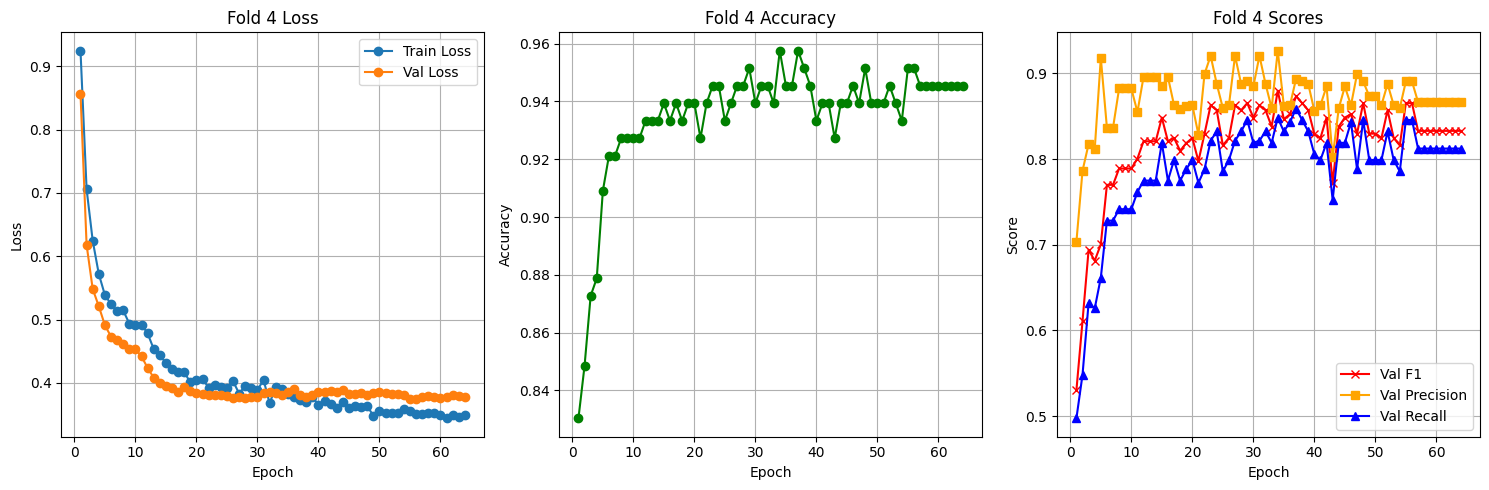


--- Cross-validation F1-score ---
Median F1 ± Range: 0.8750 ± 0.0091 (Best: 0.8798, Worst: 0.8707)


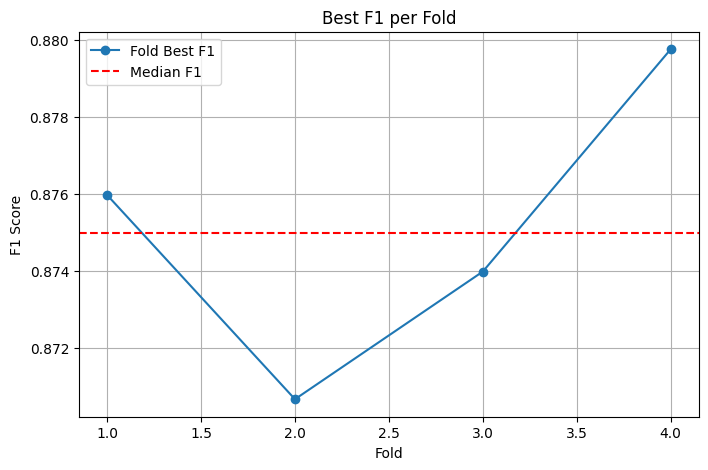

Submission saved at: prediction/submission_MLP_majority.csv


In [2]:

    

if PREPROCESSING_VISUAL_CHECK:
    top3_acf_table = top3_acf_lags(X_train_enc, gaussian_joints + exp_joints, sample_id=0)
    for feature, group in top3_acf_table.groupby('feature'):
        print(f"\nFeature: {feature}")
        top3 = group.sort_values('acf_value', ascending=False)
        for i, row in top3.iterrows():
            print(f"  Lag: {row['lag']}, ACF: {row['acf_value']:.4f}")

# --------------------------
# PIPELINE
# --------------------------

# Gaussian
X_train_enc, X_test_enc = apply_preprocessing(X_train_enc, X_test_enc, gaussian_joints, PREPROCESSING_OPTS["gaussian"])
X_train_enc, X_test_enc = apply_scaler(X_train_enc, X_test_enc, gaussian_joints, SCALER_OPTS["gaussian"])

# Exponential
X_train_enc, X_test_enc = apply_preprocessing(X_train_enc, X_test_enc, exp_joints, PREPROCESSING_OPTS["exp"])
X_train_enc, X_test_enc = apply_scaler(X_train_enc, X_test_enc, exp_joints, SCALER_OPTS["exp"])

# Pain survey integers
X_train_enc, X_test_enc = apply_preprocessing(X_train_enc, X_test_enc, pain_cols, PREPROCESSING_OPTS["pain"])
X_train_enc, X_test_enc = apply_scaler(X_train_enc, X_test_enc, pain_cols, SCALER_OPTS["pain"])

# Final feature columns
feature_cols = pain_cols + gaussian_joints + exp_joints + onehot_cols + other_cols


label_mapping = {label: idx for idx, label in enumerate(sorted(y_train['label'].unique()))}
y_train['label_encoded'] = y_train['label'].map(label_mapping)


# --------------------------
# FUNZIONE FEATURE ENGINEERING
# --------------------------
def add_features(df, joint_cols, time_col='time', window_sizes=[], time_mods=[24,48,60]):
    """
    Aggiunge features dai joint e dal tempo (moduli).
    """
    print(f"Adding BASE engineered features for {len(joint_cols)} joint columns...")
    df_new = df.copy()
    new_features = {}

    for col in tqdm(joint_cols, desc="Base Feature Engineering", ncols=80):
        x = df_new[col].fillna(0).values

        # Derivative 1° ordine
        # new_features[f"{col}_diff1"] = np.diff(np.insert(x, 0, x[0]))

        for w in window_sizes:
            roll_mean = uniform_filter1d(x, size=w, mode='nearest')
            cumsum = uniform_filter1d(x**2, size=w, mode='nearest')
            roll_std = np.sqrt(np.maximum(cumsum - roll_mean**2, 0))

            new_features[f"{col}_rollmean_{w}"] = roll_mean
            new_features[f"{col}_rollstd_{w}"] = roll_std

    if time_col in df_new.columns:
        t = df_new[time_col].fillna(0).values
        for mod in time_mods:
            new_features[f"time_sin{mod}"] = np.sin(2 * np.pi * t / mod)
            new_features[f"time_cos{mod}"] = np.cos(2 * np.pi * t / mod)

    new_df = pd.DataFrame(new_features, index=df_new.index)

    scaler = StandardScaler()
    new_df[new_df.columns] = scaler.fit_transform(new_df)

    df_new = pd.concat([df_new, new_df], axis=1)
    return df_new


# --------------------------
# ESEMPIO USO
# --------------------------
all_joint_cols = gaussian_joints + exp_joints
time_mods = [14, 24]

print("\n--- Feature Engineering Pipeline ---")
os.makedirs("dataset", exist_ok=True)

# --- INFO DATASET ---
'''
print("\n--- Dataset info ---")
print(f"X_train shape: {X_train_enc.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test_enc.shape}")
''' 

if PREPROCESSING_VISUAL_CHECK:
    num_train_samples = X_train_enc['sample_index'].nunique()
    num_test_samples = X_test_enc['sample_index'].nunique()
    print(f"Number of training sequences: {num_train_samples}")
    print(f"Number of test sequences: {num_test_samples}")
    num_features = len(feature_cols)
    print(f"Number of features used: {num_features}")
    timesteps_per_seq = X_train_enc.groupby('sample_index').size()
    print(f"Timesteps per training sequence: min={timesteps_per_seq.min()}, max={timesteps_per_seq.max()}, mean={int(timesteps_per_seq.mean())}")
    timesteps_per_seq_test = X_test_enc.groupby('sample_index').size()
    print(f"Timesteps per test sequence: min={timesteps_per_seq_test.min()}, max={timesteps_per_seq_test.max()}, mean={int(timesteps_per_seq_test.mean())}")
    label_counts = y_train['label'].value_counts()
    print("\nLabel distribution:")
    print(label_counts)
    print("\nLabel to index mapping:")
    print(label_mapping)

if LOAD_DATASET:
    with open("dataset/X_train_enc.pkl", "rb") as f:
        X_train_enc = pickle.load(f)
    with open("dataset/X_test_enc.pkl", "rb") as f:
        X_test_enc = pickle.load(f)
    print("Dataset caricati da 'dataset/'. Nessuna nuova feature aggiunta.")
    feature_cols = [c for c in X_train_enc.columns if c not in categorical_cols]

elif ADD_FEATURES:
    X_train_enc = add_features(X_train_enc, all_joint_cols, time_col='time', time_mods=time_mods)
    X_test_enc = add_features(X_test_enc, all_joint_cols, time_col='time', time_mods=time_mods)

    with open("dataset/X_train_enc.pkl", "wb") as f:
        pickle.dump(X_train_enc, f)
    with open("dataset/X_test_enc.pkl", "wb") as f:
        pickle.dump(X_test_enc, f)

    print("New features added and datasets saved to 'dataset/'.")
    feature_cols = [c for c in X_train_enc.columns if c not in categorical_cols + ['time', 'sample_index']]

else:
    print("Using raw preprocessed dataset (no feature engineering).")
    feature_cols = pain_cols + gaussian_joints + exp_joints + onehot_cols

print(f"Total feature columns: {len(feature_cols)}")


# --------------------------
# Data check
# --------------------------
print("Final preprocessing summary:")
print(f"Pain cols: {pain_cols}")
print(f"Gaussian joints: {gaussian_joints}")
print(f"Exponential joints: {exp_joints}")
print(f"One-hot cols: {onehot_cols}")
print(f"Preprocessing: {PREPROCESSING_OPTS}")
print(f"Scalers: {SCALER_OPTS}")

if PREPROCESSING_VISUAL_CHECK:
    for group_name, cols in {
        "Gaussian": gaussian_joints[:3],
        "Exponential": exp_joints[:3],
        "Pain": pain_cols[:3]
    }.items():
        for col in cols:
            plt.figure(figsize=(6, 3))
            plt.hist(X_train_enc[col], bins=50, alpha=0.7)
            plt.title(f"{group_name} → {col}")
            plt.grid(True)
            plt.tight_layout()
            plt.show()

print(f"Final feature columns ({len(feature_cols)}): {feature_cols[:10]} ...")


def analyze_features_for_group(df, feature_cols, group_ids, time_col='time', sample_idx_col='sample_index', save_plots=False, plot_dir="plots"):

    if isinstance(group_ids, (int, str)):
        group_ids = [group_ids]

    df_group = df[df[sample_idx_col].isin(group_ids)]

    if df_group.empty:
        print(f"Nessun dato trovato per i gruppi {group_ids}")
        return {}

    if save_plots and not os.path.exists(plot_dir):
        os.makedirs(plot_dir)

    stats_summary = {}

    for col in feature_cols:
        print(f"\n--- Analysis for {col} (groups {group_ids}) ---")

        series = df_group[col]

        is_bool = set(series.unique()).issubset({0,1})

        stats = {}
        if is_bool:

            counts_0 = (series == 0).sum()
            counts_1 = (series == 1).sum()
            total = counts_0 + counts_1
            prop_0 = counts_0 / total if total > 0 else np.nan
            prop_1 = counts_1 / total if total > 0 else np.nan
            stats = {
                'counts_0': counts_0,
                'counts_1': counts_1,
                'prop_0': prop_0,
                'prop_1': prop_1
            }
        else:
            stats = {
                'min': series.min(),
                'max': series.max(),
                'mean': series.mean(),
                'median': series.median(),
                'std': series.std(),
                '25%': series.quantile(0.25),
                '75%': series.quantile(0.75),
            }

        stats_summary[col] = stats
        for k, v in stats.items():
            print(f"{k}: {v}")


        plt.figure(figsize=(8,4))
        for idx, df_sub in df_group.groupby(sample_idx_col):
            plt.plot(df_sub[time_col], df_sub[col], label=f"{sample_idx_col}={idx}", alpha=0.8)
        plt.title(f"{col} over time for group(s) {group_ids}")
        plt.xlabel(time_col)
        plt.ylabel(col)
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        if save_plots:
            plt.savefig(os.path.join(plot_dir, f"{col}_groups_{'_'.join(map(str, group_ids))}.png"))
        plt.show()


        plt.figure(figsize=(6,4))
        if is_bool:
            sns.countplot(x=col, data=df_group)
        else:
            sns.histplot(series, bins=30, kde=True)
        plt.title(f"Distribution of {col} (group {group_ids})")
        plt.grid(True)
        plt.tight_layout()
        if save_plots:
            plt.savefig(os.path.join(plot_dir, f"{col}_dist_groups_{'_'.join(map(str, group_ids))}.png"))
        plt.show()

    return stats_summary


if PREPROCESSING_VISUAL_CHECK:
    stats_summary = analyze_features_for_group(X_train_enc, feature_cols, group_ids=4)
    
    print("X_train_enc shape:", X_train_enc.shape) 

    print("y_train label column:")
    print(y_train['label'].head())
    print("y_train encoded labels:")
    print(y_train['label_encoded'].unique())

    sns.countplot(x='label', data=y_train)
    plt.title("Distribution of original labels")
    plt.grid(True)
    plt.show()

    sns.countplot(x='label_encoded', data=y_train)
    plt.title("Distribution of encoded labels")
    plt.grid(True)
    plt.show()



# --------------------------
# AUGMENTATION FUNCTIONS
# --------------------------
def jitter(x, sigma):
    return x + np.random.normal(0, sigma, x.shape).astype(np.float32)

def scaling(x, sigma):
    factor = np.random.normal(1.0, sigma, (x.shape[1],))
    return x * factor.astype(np.float32)

def time_warp(x, max_warp):
    from scipy.interpolate import interp1d
    L, D = x.shape
    warp = np.linspace(0, L-1, num=L) + np.random.uniform(-max_warp*L, max_warp*L, size=L)
    warp = np.clip(warp, 0, L-1)
    f = interp1d(np.arange(L), x, axis=0, kind='linear', fill_value="extrapolate")
    return f(warp).astype(np.float32)

def random_mask(x, max_ratio):
    L, D = x.shape
    mask_len = int(L * np.random.uniform(0, max_ratio))
    if mask_len == 0: return x
    start = np.random.randint(0, L - mask_len)
    x[start:start+mask_len, :] = 0
    return x

def augment_sequence(x, opts=AUGMENTATION_OPTS):
    x_aug = x.copy()
    if opts["jitter"]: x_aug = jitter(x_aug, opts["jitter_sigma"])
    if opts["scaling"]: x_aug = scaling(x_aug, opts["scaling_sigma"])
    if opts["time_warp"]: x_aug = time_warp(x_aug, opts["time_warp_max"])
    if opts["random_mask"]: x_aug = random_mask(x_aug, opts["mask_max_ratio"])
    return x_aug

# --------------------------
# SEQUENCE DATASET WITH AUGMENTATION
# --------------------------
class PiratePainSeqDataset(Dataset):
    def __init__(self, X, y=None, augment=False):
        self.X, self.y = [], []
        self.augment = augment

        if y is not None:
            y_map = y.set_index('sample_index')['label'].map(label_mapping)

        for idx, df_sub in X.groupby('sample_index'):
            seq = df_sub[feature_cols].values.astype(np.float32)
            self.X.append(seq)
            if y is not None:
                if idx not in y_map.index:
                    raise ValueError(f"sample_index {idx} non trovato in y_train")
                self.y.append(y_map.loc[idx])

            if self.augment and y is not None:
                for _ in range(AUGMENTATION_OPTS["n_augmented"]):
                    self.X.append(augment_sequence(seq))
                    self.y.append(y_map.loc[idx])

        if y is not None:
            self.y = np.array(self.y)
        else:
            self.y = None

        # print(f"\nTotal sequences loaded: {len(self.X)}")
        # if y is not None:
            #print(f"Total labels loaded: {len(self.y)}")

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x = torch.tensor(self.X[idx], dtype=torch.float32)
        if self.y is not None:
            return x, torch.tensor(self.y[idx], dtype=torch.long)
        return x


def collate_fn(batch):
    x, y = zip(*batch) if isinstance(batch[0], tuple) else (batch, None)
    x_padded = nn.utils.rnn.pad_sequence(x, batch_first=True)
    if y is not None:
        y = torch.stack(y)
        return x_padded, y
    return x_padded

# --------------------------
# DATASETS & LOADERS (GroupKFold) 
# --------------------------
print("\n--- Creating GroupKFold datasets & loaders ---")

# Array delle sequenze
unique_samples = y_train['sample_index'].values          
y_seq = y_train['label'].map(label_mapping).values       
groups = unique_samples                                    
X_dummy = np.zeros((len(unique_samples), 1))

gkf = GroupKFold(n_splits=K_FOLDS)
folds = list(gkf.split(X_dummy, y_seq, groups=groups))

print(f"\nCreated {K_FOLDS} folds for GroupKFold cross-validation.")

test_dataset = PiratePainSeqDataset(X_test_enc, augment=False)
test_loader  = DataLoader(test_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn)

for i, (train_idx, val_idx) in enumerate(folds, 1):
    train_samples = unique_samples[train_idx]
    val_samples = unique_samples[val_idx]
    # print(f"Fold {i}: {len(train_samples)} train samples, {len(val_samples)} val samples")


'''
# --------------------------
# SEQUENCE DATASET
# --------------------------
class PiratePainSeqDataset(Dataset):
    def __init__(self, X, y=None):
        self.X, self.y = [], []

        if y is not None:
            y_map = y.set_index('sample_index')['label'].map(label_mapping)
            # print("\nMapping sample_index -> label:\n", y_map.head())

        for idx, df_sub in X.groupby('sample_index'):
            # print(f"\nProcessing sample_index {idx}, seq length {len(df_sub)}")
            seq = df_sub[feature_cols].values.astype(np.float32)
            self.X.append(seq)
            if y is not None:
                if idx not in y_map.index:
                    raise ValueError(f"sample_index {idx} non trovato in y_train")
                self.y.append(y_map.loc[idx])

        print(f"\nTotal sequences loaded: {len(self.X)}")
        if y is not None:
            self.y = np.array(self.y)
            print(f"Total labels loaded: {len(self.y)}")
        else:
            self.y = None

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x = torch.tensor(self.X[idx], dtype=torch.float32)
        if self.y is not None:
            return x, torch.tensor(self.y[idx], dtype=torch.long)
        return x


# Collate function padding sequenze
def collate_fn(batch):
    x, y = zip(*batch) if isinstance(batch[0], tuple) else (batch, None)
    x_padded = nn.utils.rnn.pad_sequence(x, batch_first=True)
    if y is not None:
        y = torch.stack(y)
        return x_padded, y
    return x_padded

# Datasets & Loaders
print("\n--- Creating datasets & loaders ---")
dataset = PiratePainSeqDataset(X_train_enc, y_train)
train_idx, val_idx = train_test_split(
    np.arange(len(dataset)), test_size=VALID_SPLIT, stratify=dataset.y, random_state=SEED
)
train_dataset = torch.utils.data.Subset(dataset, train_idx)
val_dataset = torch.utils.data.Subset(dataset, val_idx)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn)

test_dataset = PiratePainSeqDataset(X_test_enc)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn)

print(f"\nTrain sequences: {len(train_dataset)}, Validation sequences: {len(val_dataset)}, Test sequences: {len(test_dataset)}")
'''


# --------------------------
# MODELS
# --------------------------
input_dim = len(feature_cols)
num_classes = len(label_mapping)

# ATTENTIVE POOLING 1D
class AttentivePooling1D(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.attention = nn.Linear(input_dim, 1)

    def forward(self, x):
        scores = self.attention(x)
        weights = F.softmax(scores, dim=1)
        x_pooled = (x * weights).sum(dim=1)
        return x_pooled

# LSTM MODEL 
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_size, num_layers, num_classes, dropout):
        super().__init__()
        self.lstm = nn.LSTM(
            input_dim, hidden_size, num_layers=num_layers,
            batch_first=True, dropout=dropout, bidirectional=True
        )
        self.fc = nn.Linear(hidden_size*2, num_classes)

    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :])
    
    
# GRU 
class GRUModel(nn.Module):
    def __init__(self, input_dim, hidden_size=512, num_layers=4, num_classes=10, dropout=0.3):
        super().__init__()
        self.gru = nn.GRU(
            input_dim, hidden_size, num_layers=num_layers,
            batch_first=True, dropout=dropout, bidirectional=True
        )
        self.layer_norm = nn.LayerNorm(hidden_size*2)
        self.att_pool = AttentivePooling1D(hidden_size*2)
        self.fc = nn.Linear(hidden_size*2, num_classes)

    def forward(self, x):
        out, _ = self.gru(x)
        out = self.layer_norm(out)
        out = self.att_pool(out)
        return self.fc(out)
    

# TIMESNET MODEL
class AttentivePooling1D(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.att = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        # x: [B, L, H]
        weights = torch.softmax(self.att(x), dim=1)  # [B,L,1]
        return (x * weights).sum(dim=1)             # [B,H]


class TimesBlock(nn.Module):
    def __init__(self, hidden_dim, periods=[4,8,16,32], dropout=0.2):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.periods = periods
        self.convs = nn.ModuleList([
            nn.Conv2d(hidden_dim, hidden_dim, kernel_size=(1,p), padding=(0,p//2))
            for p in periods
        ])
        self.layer_norm = nn.LayerNorm(hidden_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # x: [B,L,H]
        B, L, H = x.size()
        x_in = x
        conv_outs = []

        for i, p in enumerate(self.periods):
            if L < p:
                continue
            # reshape for Conv2d: [B,H,L,1]
            x_reshaped = x.permute(0,2,1).unsqueeze(-1)
            conv_out = F.relu(self.convs[i](x_reshaped))   # [B,H,L,1]
            # safely squeeze last dim
            conv_out = conv_out[..., 0].permute(0,2,1)    # [B,L,H]
            conv_outs.append(conv_out)

        if len(conv_outs) == 0:
            x_out = x
        else:
            x_out = sum(conv_outs) / len(conv_outs)

        x_out = self.dropout(x_out)
        return self.layer_norm(x_in + x_out)  


class TimesNet(nn.Module):
    """Full TimesNet model for classification/regression"""
    def __init__(self, input_dim, num_classes, hidden_dim=192, num_blocks=4,
                 max_seq_len=500, dropout=0.2, periods=[4,8,16,32]):
        super().__init__()
        self.input_fc = nn.Linear(input_dim, hidden_dim)
        self.pos_enc = nn.Parameter(torch.randn(1, max_seq_len, hidden_dim))
        self.blocks = nn.ModuleList([TimesBlock(hidden_dim, periods=periods, dropout=dropout)
                                     for _ in range(num_blocks)])
        self.att_pool = AttentivePooling1D(hidden_dim)
        self.fc = nn.Linear(hidden_dim, num_classes)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # x: [B,L,input_dim]
        B, L, _ = x.size()
        x = self.input_fc(x)
        x = x + self.pos_enc[:, :L, :]  
        for block in self.blocks:
            x = block(x)
        x = self.att_pool(x)
        x = self.dropout(x)
        return self.fc(x)


# TRANSFORMER 
class TransformerModel(nn.Module):
    def __init__(self, input_dim, num_classes, hidden_dim=192, nhead=4, num_layers=2, max_seq_len=500, dropout=0.4):
        super().__init__()
        self.input_fc = nn.Linear(input_dim, hidden_dim)
        self.pos_enc = nn.Parameter(torch.randn(1, max_seq_len, hidden_dim))
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=hidden_dim,
            nhead=nhead,
            dropout=dropout,
            batch_first=True,
            dim_feedforward=hidden_dim*4,
            activation='gelu'
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.layer_norm = nn.LayerNorm(hidden_dim)
        self.att_pool = AttentivePooling1D(hidden_dim)
        self.fc = nn.Linear(hidden_dim, num_classes)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        x = self.input_fc(x)
        seq_len = x.size(1)
        x = x + self.pos_enc[:, :seq_len, :]
        x = self.transformer(x, src_key_padding_mask=mask)
        x = self.layer_norm(x)
        x = self.att_pool(x)
        x = self.dropout(x)
        return self.fc(x)

''' 
class TransformerModel(nn.Module):
    def __init__(self, input_dim, num_classes, hidden_dim, nhead, num_layers, max_seq_len, dropout):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.input_fc = nn.Linear(input_dim, hidden_dim)
        self.pos_enc = nn.Parameter(torch.randn(1, max_seq_len, hidden_dim))

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=hidden_dim,
            nhead=nhead,
            dropout=dropout,
            batch_first=True,
            dim_feedforward=hidden_dim*4  # feed-forward expansion
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc = nn.Linear(hidden_dim, num_classes)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        x = self.input_fc(x)
        seq_len = x.size(1)
        x = x + self.pos_enc[:, :seq_len, :]
        x = self.transformer(x, src_key_padding_mask=mask)
        x = x.mean(dim=1)
        x = self.dropout(x)
        return self.fc(x)
'''

# TCN MODEL
class SEBlock1D(nn.Module):
    def __init__(self, channels, reduction=16):
        super().__init__()
        self.fc1 = nn.Linear(channels, channels // reduction)
        self.fc2 = nn.Linear(channels // reduction, channels)

    def forward(self, x):
        y = x.mean(dim=2)
        y = F.relu(self.fc1(y))
        y = torch.sigmoid(self.fc2(y)).unsqueeze(-1)
        return x * y

class TemporalBlockInception(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_sizes=[3,5,7], dilation=1, dropout=0.3):
        super().__init__()
        # Multi-kernel convolutions
        self.convs = nn.ModuleList()
        for k in kernel_sizes:
            pad = ((k-1)*dilation)//2
            self.convs.append(
                nn.Conv1d(in_channels, out_channels, kernel_size=k, padding=pad, dilation=dilation)
            )
        self.bn = nn.BatchNorm1d(out_channels)
        self.relu = nn.GELU()
        self.dropout = nn.Dropout(dropout)
        self.se = SEBlock1D(out_channels)
        # Residual connection
        self.skip = nn.Conv1d(in_channels, out_channels, 1) if in_channels != out_channels else nn.Identity()

    def forward(self, x):
        residual = self.skip(x)
        out = sum(conv(x) for conv in self.convs)
        out = self.bn(out)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.se(out)
        out += residual
        return self.relu(out)

class TCNModel(nn.Module):
    def __init__(self, input_dim, num_classes, conv_channels, kernel_sizes_list, dilation_list=None, dropout=0.3):
        super().__init__()
        layers = []
        in_channels = input_dim

        if dilation_list is None:
            dilation_list = [2**i for i in range(len(conv_channels))]

        for out_channels, ks, d in zip(conv_channels, kernel_sizes_list, dilation_list):
            if isinstance(ks, int):
                ks = [ks]
            layers.append(
                TemporalBlockInception(in_channels, out_channels, kernel_sizes=ks, dilation=d, dropout=dropout)
            )
            in_channels = out_channels

        layers.append(nn.AdaptiveMaxPool1d(1))  # global aggregation
        self.tcn = nn.Sequential(*layers)
        self.fc = nn.Linear(conv_channels[-1], num_classes)

    def forward(self, x):
        x = x.transpose(1,2)  # [batch, features, seq_len]
        x = self.tcn(x)
        x = x.squeeze(-1)     # [batch, channels]
        return self.fc(x)


# CNN1D MODEL
class SEBlock1D(nn.Module):
    def __init__(self, channels, reduction=16):
        super().__init__()
        self.fc1 = nn.Linear(channels, channels // reduction)
        self.fc2 = nn.Linear(channels // reduction, channels)

    def forward(self, x):
        y = x.mean(dim=2)
        y = F.relu(self.fc1(y))
        y = torch.sigmoid(self.fc2(y)).unsqueeze(-1)
        return x * y

class ResidualBlockInception1DDilated(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_sizes=[3,5,7], dilation=2, dropout=0.3):
        super().__init__()
        self.convs = nn.ModuleList()
        for k in kernel_sizes:
            self.convs.append(
                nn.Conv1d(in_channels, out_channels, kernel_size=k, padding=(k//2)*dilation, dilation=dilation)
            )
        self.bn = nn.BatchNorm1d(out_channels)
        self.relu = nn.GELU()
        self.dropout = nn.Dropout(dropout)
        self.se = SEBlock1D(out_channels)
        self.skip = nn.Conv1d(in_channels, out_channels, 1) if in_channels != out_channels else nn.Identity()

    def forward(self, x):
        residual = self.skip(x)
        out = sum(conv(x) for conv in self.convs)
        out = self.bn(out)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.se(out)
        out += residual
        out = self.relu(out)
        return out

class CNN1DModel(nn.Module):
    def __init__(self, input_dim, num_classes, conv_channels, kernel_sizes_list, dilation_list=None, dropout=0.3):
        super().__init__()
        layers = []
        in_channels = input_dim
        if dilation_list is None:
            dilation_list = [1]*len(conv_channels)  # default dilation=1
        for out_channels, ks, d in zip(conv_channels, kernel_sizes_list, dilation_list):
            if isinstance(ks, int):
                ks = [ks]
            layers.append(
                ResidualBlockInception1DDilated(in_channels, out_channels, kernel_sizes=ks, dilation=d, dropout=dropout)
            )
            in_channels = out_channels
        layers.append(nn.AdaptiveMaxPool1d(1))
        self.conv = nn.Sequential(*layers)
        self.fc = nn.Linear(conv_channels[-1], num_classes)

    def forward(self, x):
        x = x.transpose(1,2)  # [batch, features, seq_len]
        x = self.conv(x)
        x = x.squeeze(-1)
        return self.fc(x)
    
'''
class SEBlock1D(nn.Module):
    def __init__(self, channels, reduction=16):
        super().__init__()
        self.fc1 = nn.Linear(channels, channels // reduction)
        self.fc2 = nn.Linear(channels // reduction, channels)

    def forward(self, x):
        y = x.mean(dim=2)
        y = F.relu(self.fc1(y))
        y = torch.sigmoid(self.fc2(y)).unsqueeze(-1)
        return x * y

class ResidualBlockInception1D(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_sizes=[3,5,7], dropout=0.3):
        super().__init__()
        self.convs = nn.ModuleList()
        for k in kernel_sizes:
            self.convs.append(
                nn.Conv1d(in_channels, out_channels, kernel_size=k, padding=k//2)
            )
        self.bn = nn.BatchNorm1d(out_channels)
        self.relu = nn.GELU()
        self.dropout = nn.Dropout(dropout)
        self.se = SEBlock1D(out_channels)
        self.skip = nn.Conv1d(in_channels, out_channels, 1) if in_channels != out_channels else nn.Identity()

    def forward(self, x):
        residual = self.skip(x)
        out = sum(conv(x) for conv in self.convs)
        out = self.bn(out)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.se(out)
        out += residual
        out = self.relu(out)
        return out

class CNN1DModel(nn.Module):
    def __init__(self, input_dim, num_classes, conv_channels, kernel_sizes_list, dropout=0.3):
        super().__init__()
        layers = []
        in_channels = input_dim
        for out_channels, ks in zip(conv_channels, kernel_sizes_list):
            if isinstance(ks, int):
                ks = [ks]
            layers.append(ResidualBlockInception1D(in_channels, out_channels, kernel_sizes=ks, dropout=dropout))
            in_channels = out_channels
        layers.append(nn.AdaptiveMaxPool1d(1))
        self.conv = nn.Sequential(*layers)
        self.fc = nn.Linear(conv_channels[-1], num_classes)

    def forward(self, x):
        x = x.transpose(1,2) 
        x = self.conv(x)
        x = x.squeeze(-1)
        return self.fc(x)
'''

# --------------------------
# MLP MODEL
# --------------------------
class MLPModel(nn.Module):
    def __init__(self, input_dim, hidden_sizes, num_classes, dropout):
        super().__init__()
        layers = []
        in_dim = input_dim
        for h in hidden_sizes:
            layers.append(nn.Linear(in_dim, h))
            layers.append(nn.BatchNorm1d(h))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout))
            in_dim = h
        layers.append(nn.Linear(hidden_sizes[-1], num_classes))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        x = x.mean(dim=1) 
        return self.net(x)
    
'''
class MLPModel(nn.Module):
    def __init__(self, input_dim, hidden_sizes, num_classes, dropout=0.3):
        super().__init__()
        self.att_pool = AttentivePooling1D(input_dim)
        layers = []
        in_dim = input_dim
        for h in hidden_sizes:
            layers.append(nn.Linear(in_dim, h))
            layers.append(nn.LayerNorm(h))
            layers.append(nn.GELU())
            layers.append(nn.Dropout(dropout))
            in_dim = h
        layers.append(nn.Linear(hidden_sizes[-1], num_classes))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        x = self.att_pool(x)
        return self.net(x)
''' 
    
# --------------------------
# GNN MODEL
# --------------------------
class GNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes, num_layers=2, heads=4, dropout=0.3):
        super().__init__()
        self.num_layers = num_layers
        self.heads = heads
        self.dropout = dropout

        self.convs = nn.ModuleList()
        self.convs.append(GATConv(input_dim, hidden_dim, heads=heads, dropout=dropout, concat=True))
        for _ in range(num_layers-1):
            self.convs.append(GATConv(hidden_dim*heads, hidden_dim, heads=heads, dropout=dropout, concat=True))

        self.relu = nn.ReLU()
        self.att_pool = AttentivePooling1D(hidden_dim*heads)
        self.fc = nn.Linear(hidden_dim*heads, num_classes)

    def forward(self, x):
        """
        x: [batch, seq_len, input_dim]
        """
        batch_size, seq_len, feat_dim = x.size()

        device = x.device
        edge_indices = []
        for b in range(batch_size):
            row = torch.arange(seq_len-1, device=device) + b*seq_len
            col = torch.arange(1, seq_len, device=device) + b*seq_len
            edge_index = torch.stack([torch.cat([row, col]), torch.cat([col, row])], dim=0)
            edge_indices.append(edge_index)
        edge_index = torch.cat(edge_indices, dim=1)  

        x = x.reshape(batch_size*seq_len, feat_dim)

        for conv in self.convs:
            x = conv(x, edge_index)
            x = self.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)

        x = x.view(batch_size, seq_len, -1)
        x = self.att_pool(x)

        return self.fc(x)

'''
class GNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes, num_layers=2, dropout=0.3):
        super().__init__()
        self.num_layers = num_layers
        self.dropout = dropout

        # --- GCN layers ---
        self.convs = nn.ModuleList()
        self.convs.append(GCNConv(input_dim, hidden_dim))
        for _ in range(num_layers-1):
            self.convs.append(GCNConv(hidden_dim, hidden_dim))

        self.relu = nn.ReLU()
        self.dropout_layer = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        """
        x: [batch, seq_len, input_dim]
        """
        batch_size, seq_len, feat_dim = x.size()
        device = x.device

        edge_indices = []
        for b in range(batch_size):
            row = torch.arange(seq_len-1, device=device) + b*seq_len
            col = torch.arange(1, seq_len, device=device) + b*seq_len
            edge_index = torch.stack([torch.cat([row, col]), torch.cat([col, row])], dim=0)
            edge_indices.append(edge_index)
        edge_index = torch.cat(edge_indices, dim=1)  # concateni tutti i batch

        # Flatten batch: [batch*seq_len, input_dim]
        x = x.view(batch_size*seq_len, feat_dim)

        for conv in self.convs:
            x = conv(x, edge_index)
            x = self.relu(x)
            x = self.dropout_layer(x)

        x = x.view(batch_size, seq_len, -1)  # [batch, seq_len, hidden_dim]
        x = x.mean(dim=1)  # aggrega timestep

        return self.fc(x)
'''

# BAYESIAN NEURAL NETWORK (BNN) MODEL
import torchbnn as bnn

class BayesianModel(nn.Module):
    def __init__(self, input_dim, num_classes,
                 hidden_sizes=[128,64],
                 dropout=0.2,
                 prior_mu=0.0,
                 base_prior_sigma=0.05,
                 kl_annealing_epochs=20):
        super().__init__()
        self.kl_annealing_epochs = kl_annealing_epochs
        self.current_epoch = 0

        # Encoder sequenza (deterministico)
        self.gru = nn.GRU(input_dim, hidden_sizes[0], batch_first=True, bidirectional=True)
        feat_dim = hidden_sizes[0]*2

        # Attentive pooling
        self.attn = nn.Linear(feat_dim, 1)

        # Bayesian classifier
        layers = []
        in_dim = feat_dim
        for idx, h in enumerate(hidden_sizes[1:]):
            sigma = base_prior_sigma * (1 + idx*0.5)
            layers.append(bnn.BayesLinear(prior_mu=prior_mu, prior_sigma=sigma, in_features=in_dim, out_features=h))
            layers.append(nn.BatchNorm1d(h))
            layers.append(nn.LeakyReLU(0.1))
            layers.append(nn.Dropout(dropout))
            in_dim = h
        # Output bayesiano
        layers.append(bnn.BayesLinear(prior_mu=prior_mu, prior_sigma=base_prior_sigma, in_features=in_dim, out_features=num_classes))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        # x: [batch, time, features]
        out, _ = self.gru(x)
        weights = torch.softmax(self.attn(out), dim=1)
        x_pooled = (out * weights).sum(dim=1)
        return self.net(x_pooled)

    def kl_loss(self):
        kl = 0
        kl_fn = bnn.BKLLoss(reduction="sum")
        for module in self.modules():
            if isinstance(module, bnn.BayesLinear):
                kl += kl_fn(module)
        # Annealing KL: gradualmente aumentiamo il peso
        kl_weight = min(1.0, self.current_epoch / self.kl_annealing_epochs)
        return kl * kl_weight


# CNN + GRU 
class CNN_RNN(nn.Module):
    def __init__(self, input_dim, num_classes,
                 cnn_out_channels=64,
                 cnn_kernel=5,
                 gru_hidden=128,
                 gru_layers=1,
                 dropout=0.3):
        super().__init__()
        self.cnn = nn.Conv1d(input_dim, cnn_out_channels, kernel_size=cnn_kernel, padding=cnn_kernel//2)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)

        self.gru_hidden = gru_hidden
        self.gru_layers = gru_layers
        self.gru = None  

        self.layer_norm = nn.LayerNorm(gru_hidden*2)
        self.att_pool = nn.Linear(gru_hidden*2, 1)
        self.fc = nn.Linear(gru_hidden*2, num_classes)
        self.dropout_gru = nn.Dropout(dropout)

    def forward(self, x, seq_features=None):
        
        B, T, F = x.size()

        x_cnn = x.transpose(1,2)         # [B, F, T]
        x_cnn = self.cnn(x_cnn)          # [B, C, T]
        x_cnn = self.relu(x_cnn)
        x_cnn = self.dropout(x_cnn)
        x_cnn = x_cnn.transpose(1,2)     # [B, T, C]
        gru_input = torch.cat([x, x_cnn], dim=-1)  # [B, T, F + C]

        if seq_features is not None:
            seq_tiled = seq_features.unsqueeze(1).repeat(1, T, 1)
            gru_input = torch.cat([gru_input, seq_tiled], dim=-1)  # [B, T, F + C + extra]

        if self.gru is None:
            input_dim_gru = gru_input.size(-1)
            self.gru = nn.GRU(
                input_dim_gru, self.gru_hidden, num_layers=self.gru_layers,
                batch_first=True, bidirectional=True,
                dropout=0. if self.gru_layers==1 else self.dropout_gru.p
            ).to(gru_input.device)

        out, _ = self.gru(gru_input)           # [B, T, H*2]
        out = self.layer_norm(out)

        att_weights = torch.softmax(self.att_pool(out), dim=1)  # [B, T, 1]
        out = (out * att_weights).sum(dim=1)                   # [B, H*2]
        out = self.dropout_gru(out)

        return self.fc(out)


# --------------------------
# ENSEMBLE MODEL
# --------------------------
class EnsembleModel(nn.Module):
    def __init__(self, input_dim, num_classes, device):
        super().__init__()
        self.device = device
        # --- CNN1D (Inception + Dilated + SE) ---
        self.cnn = CNN1DModel(
            input_dim=input_dim,
            num_classes=num_classes,
            conv_channels=[48, 96, 160],
            kernel_sizes_list=[
                [3, 5, 7],
                [5, 7, 9],
                [7, 9, 11]
            ],
            dropout=0.4
        )
        # --- GRU ---
        self.gru = GRUModel(
            input_dim=input_dim,
            hidden_size=192,
            num_layers=3,
            num_classes=num_classes,
            dropout=0.4
        )
        # --- LSTM ---
        self.lstm = LSTMModel(
            input_dim=input_dim,
            hidden_size=192,
            num_layers=3,
            num_classes=num_classes,
            dropout=0.4
        )
        # --- Transformer ---
        self.transformer = TransformerModel(
            input_dim=input_dim,
            num_classes=num_classes,
            hidden_dim=96,
            nhead=2,
            num_layers=3,
            max_seq_len=500,
            dropout=0.3
        )
        # --- MLP ---
        self.mlp = MLPModel(
            input_dim=input_dim,
            hidden_sizes=[384, 192, 128],
            num_classes=num_classes,
            dropout=0.4
        )
        # --- Trainable ensemble weights ---
        self.model_weights = nn.Parameter(torch.tensor([1.0, 1.0, 1.0, 1.0, 1.0]), requires_grad=True)
        self.softmax = nn.Softmax(dim=0)
    
    def forward(self, x):
        """
        Weighted ensemble forward pass
        """
        out_cnn = self.cnn(x)
        out_gru = self.gru(x)
        out_lstm = self.lstm(x)
        out_trans = self.transformer(x)
        out_mlp = self.mlp(x)

        logits = torch.stack([out_cnn, out_gru, out_lstm, out_trans, out_mlp], dim=1)
        weights = self.softmax(self.model_weights).unsqueeze(0).unsqueeze(-1)
        weighted_logits = (logits * weights).sum(dim=1)
        return weighted_logits

    def predict(self, x):
        """
        Soft ensemble prediction
        """
        with torch.no_grad():
            logits = self.forward(x)
            return torch.argmax(F.softmax(logits, dim=-1), dim=-1)

    def predict_majority(self, x, confidence_threshold=0.5):
        """
        Hard voting with fallback to weighted ensemble
        """
        with torch.no_grad():
            preds = [
                torch.argmax(F.softmax(self.cnn(x), dim=-1), dim=-1),
                torch.argmax(F.softmax(self.gru(x), dim=-1), dim=-1),
                torch.argmax(F.softmax(self.lstm(x), dim=-1), dim=-1),
                torch.argmax(F.softmax(self.transformer(x), dim=-1), dim=-1),
                torch.argmax(F.softmax(self.mlp(x), dim=-1), dim=-1)
            ]
            preds = torch.stack(preds, dim=1)
            
            majority, counts = torch.mode(preds, dim=1)
            confident = (counts.float() / preds.size(1)) >= confidence_threshold
            fallback_mask = ~confident

            if fallback_mask.any():
                weighted_preds = self.predict(x[fallback_mask])
                majority[fallback_mask] = weighted_preds

            return majority


# --------------------------
# Select model architecture
# --------------------------
models = []

for fold in range(K_FOLDS):

    if MODEL_TYPE=="LSTM":
        lstm_hidden_size = 128  
        lstm_num_layers = 2        
        lstm_dropout = 0.3
        model = LSTMModel(input_dim, lstm_hidden_size, lstm_num_layers, num_classes, lstm_dropout).to(device)

    elif MODEL_TYPE=="GRU":
        gru_hidden_size = 128
        gru_num_layers = 2
        gru_dropout = 0.3
        model = GRUModel(input_dim, gru_hidden_size, gru_num_layers, num_classes, gru_dropout).to(device)

    elif MODEL_TYPE=="Transformer":
        transformer_hidden_dim = 96 
        transformer_nhead = 2
        transformer_num_layers = 3  
        transformer_max_seq_len = 500
        transformer_dropout = 0.3
        model = TransformerModel(
            input_dim, num_classes, transformer_hidden_dim, transformer_nhead,
            transformer_num_layers, transformer_max_seq_len, transformer_dropout
        ).to(device)

    elif MODEL_TYPE=="TimesNet":
        model = TimesNet(
            input_dim=input_dim,
            num_classes=num_classes,
            hidden_dim=128,
            num_blocks=3,
            max_seq_len=500,
            dropout=0.3
        ).to(device)

    elif MODEL_TYPE=="CNN1D":
        cnn_conv_channels = [48, 96, 160]
        cnn_kernel_sizes = [
            [3, 5, 7],
            [5, 7, 9], 
            [7, 9, 11]
        ]
        cnn_dropout = 0.4

        model = CNN1DModel(
            input_dim, 
            num_classes, 
            cnn_conv_channels, 
            cnn_kernel_sizes, 
            dropout=cnn_dropout
        ).to(device)
        
    elif MODEL_TYPE=="CNN_RNN":
        cnn_out_channels = 64      
        cnn_kernel = 5           
        cnn_dropout = 0.3

        gru_hidden = 192            
        gru_layers = 2             
        gru_dropout = 0.3          

        model = CNN_RNN(
            input_dim=input_dim,
            num_classes=num_classes,
            cnn_out_channels=cnn_out_channels,
            cnn_kernel=cnn_kernel,
            gru_hidden=gru_hidden,
            gru_layers=gru_layers,
            dropout=cnn_dropout
        ).to(device)

        
        
    elif MODEL_TYPE=="TCN":
        tcn_conv_channels = [48, 96, 160]  
        tcn_kernel_sizes = [
            [3, 5, 7],
            [5, 7, 9],
            [7, 9, 11]
        ]
        tcn_dilation_list = [1, 2, 4]  
        tcn_dropout = 0.4

        model = TCNModel(
            input_dim,
            num_classes,
            tcn_conv_channels,
            tcn_kernel_sizes,
            dilation_list=tcn_dilation_list,
            dropout=tcn_dropout
        ).to(device)

    elif MODEL_TYPE=="MLP":
        mlp_hidden_sizes = [256, 128, 64]
        mlp_dropout = 0.3
        model = MLPModel(input_dim, mlp_hidden_sizes, num_classes, mlp_dropout).to(device)

    elif MODEL_TYPE=="GNN":
        gnn_hidden_dim = 96
        gnn_num_layers = 2
        gnn_dropout = 0.2
        model = GNNModel(
            input_dim=input_dim,
            hidden_dim=gnn_hidden_dim,
            num_classes=num_classes,
            num_layers=gnn_num_layers,
            dropout=gnn_dropout
        ).to(device)
        
    elif MODEL_TYPE=="BNN":
        bnn_hidden_sizes = [256, 128, 64]
        bnn_dropout = 0.3
        model = BayesianModel(
            input_dim=input_dim,
            hidden_sizes=bnn_hidden_sizes,
            num_classes=num_classes,
            dropout=bnn_dropout
        ).to(device)

    elif MODEL_TYPE=="Ensemble":
        model = EnsembleModel(input_dim, num_classes, device).to(device)

    else:
        raise ValueError("MODEL_TYPE must be one of: LSTM, GRU, Transformer, CNN1D, MLP, GNN, Ensemble")

    # print(f"\n Model {MODEL_TYPE} initialized for fold {fold+1}/{K_FOLDS}")

    models.append(model)

# --------------------------
# LOSS & OPTIMIZER
# --------------------------
'''
classes = np.unique(y_train['label'].map(label_mapping))
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train['label'].map(label_mapping))
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)

class CombinedLoss(nn.Module):
    def __init__(self, gamma=2, weight=None, alpha=0.5):
        super().__init__()
        self.gamma = gamma
        self.weight = weight
        self.alpha = alpha 
        self.ce = nn.CrossEntropyLoss(weight=weight)

    def forward(self, input, target):
        ce_loss = self.ce(input, target)
        ce_loss_none = nn.CrossEntropyLoss(weight=self.weight, reduction='none')(input, target)
        pt = torch.exp(-ce_loss_none)
        focal_loss = ((1 - pt) ** self.gamma * ce_loss_none).mean()
        combined = self.alpha * ce_loss + (1 - self.alpha) * focal_loss
        return combined

# criterion = CombinedLoss(gamma=2, weight=class_weights, alpha=1.0)
# criterion = nn.CrossEntropyLoss(weight=class_weights)
# criterion = nn.CrossEntropyLoss()
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-4, amsgrad=True)
# optimizer = torch.optim.SGD(model.parameters(), lr=LR, momentum=0.9)


if MODEL_TYPE in []:
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode='min',
        factor=0.3,
        patience=5,
        min_lr=1e-6
    )
elif MODEL_TYPE in ["Transformer", "TimesNet", "CNN1D", "MLP", "GNN", "TCN", "LSTM", "GRU", "CNN_RNN"]:
    scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
        optimizer,
        T_0=10,
        T_mult=2, 
        eta_min=1e-5
    )
elif MODEL_TYPE == "BNN":
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode='min',
        factor=0.3,
        patience=10,
        min_lr=1e-6
    )
elif MODEL_TYPE == "Ensemble":
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer,
        T_max=NUM_EPOCHS,
        eta_min=1e-6
    )


else:
    raise ValueError("MODEL_TYPE must be one of: LSTM, GRU, Transformer, CNN1D, MLP, GNN, Ensemble, TCN, TimesNet")

print(f"\n Loss & Optimizer set for {MODEL_TYPE}")

'''

# --------------------------
# GROUPKFOLD TRAINING LOOP
# --------------------------
print("\n--- GroupKFold Training ---")

# Sequenze uniche e labels
unique_samples = y_train['sample_index'].values         
y_seq = y_train['label'].map(label_mapping).values   
groups = unique_samples                                 

# Dummy X per GroupKFold
X_dummy = np.zeros((len(unique_samples), 1))
gkf = GroupKFold(n_splits=K_FOLDS)

fold_scores = []
all_logs = []

for fold, (train_idx, val_idx) in enumerate(gkf.split(X_dummy, y_seq, groups=groups), 1):
    # print(f"\n--- Fold {fold}/{K_FOLDS} ---")

    train_samples = unique_samples[train_idx]
    val_samples = unique_samples[val_idx]

    train_dataset = PiratePainSeqDataset(
        X_train_enc[X_train_enc['sample_index'].isin(train_samples)],
        y_train[y_train['sample_index'].isin(train_samples)],
        augment=True
    )
    val_dataset = PiratePainSeqDataset(
        X_train_enc[X_train_enc['sample_index'].isin(val_samples)],
        y_train[y_train['sample_index'].isin(val_samples)],
        augment=False
    )

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn)

    # print(f"Train sequences: {len(train_dataset)}, Validation sequences: {len(val_dataset)}")


# --------------------------
# TRAINING LOOP PER FOLD
# --------------------------
fold_scores = []
all_logs = []

hyperparams = {
    "MODEL_TYPE": MODEL_TYPE,
    "NUM_EPOCHS": NUM_EPOCHS,
    "BATCH_SIZE": BATCH_SIZE,
    "LEARNING_RATE": LR,
    "EARLY_STOPPING_PATIENCE": EARLY_STOPPING_PATIENCE,
    "K_FOLDS": K_FOLDS,
    "WEIGHT_DECAY": 1e-4,
    "MAX_GRAD_NORM": 5.0,
    
    "PREPROCESSING_OPTS": PREPROCESSING_OPTS,
    "SCALER_OPTS": SCALER_OPTS,
    "AUGMENTATION_OPTS": AUGMENTATION_OPTS,

    "SEED": SEED,
    "DEVICE": str(device),
    "TIMESTAMP": timestamp
}

hyperparams_path = os.path.join(PRED_DIR, f"hyperparameters_{MODEL_TYPE}_{timestamp}.json")
with open(hyperparams_path, "w") as f:
    json.dump(hyperparams, f, indent=4)

print(f"Hyperparameters saved to {hyperparams_path}")


log_txt_path = os.path.join(PRED_DIR, f"training_log_{MODEL_TYPE}.txt")
with open(log_txt_path, "w") as log_file:

    for fold, (train_idx, val_idx) in enumerate(gkf.split(X_dummy, y_seq, groups=groups), 1):
        print(f"\n--- Fold {fold}/{K_FOLDS} ---")
        log_file.write(f"\n--- Fold {fold}/{K_FOLDS} ---\n")

        model = models[fold-1]
        optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-4, amsgrad=True)
        criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

        if MODEL_TYPE in ["Transformer", "TimesNet", "CNN1D", "MLP", "GNN", "TCN", "LSTM", "GRU", "CNN_RNN"]:
            scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
                optimizer, T_0=10, T_mult=2, eta_min=1e-5
            )
        elif MODEL_TYPE == "BNN":
            scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
                optimizer, mode='min', factor=0.3, patience=10, min_lr=1e-6
            )
        elif MODEL_TYPE == "Ensemble":
            scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
                optimizer, T_max=NUM_EPOCHS, eta_min=1e-6
            )

        best_val_f1 = float('-inf')
        early_stop_counter = 0
        logs = []

        for epoch in range(1, NUM_EPOCHS + 1):
            model.train()
            total_loss = 0

            for X_batch, y_batch in tqdm(train_loader, desc=f"Fold {fold} Epoch {epoch} Training"):
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                optimizer.zero_grad()
                y_pred = model(X_batch)

                if MODEL_TYPE == "BNN":
                    ce_loss = criterion(y_pred, y_batch)
                    kl = model.kl_loss() / len(train_loader.dataset)
                    loss = ce_loss + 1e-4 * kl
                else:
                    loss = criterion(y_pred, y_batch)

                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
                optimizer.step()
                total_loss += loss.item()

            train_loss = total_loss / len(train_loader)

            # Validation
            model.eval()
            val_loss = 0
            all_preds, all_labels = [], []

            with torch.no_grad():
                for X_batch, y_batch in val_loader:
                    X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                    y_pred = model(X_batch)
                    val_loss += criterion(y_pred, y_batch).item()
                    all_preds.append(y_pred.argmax(1).cpu().numpy())
                    all_labels.append(y_batch.cpu().numpy())

            val_loss /= len(val_loader)
            all_preds = np.concatenate(all_preds)
            all_labels = np.concatenate(all_labels)

            val_acc = accuracy_score(all_labels, all_preds)
            val_precision = precision_score(all_labels, all_preds, average='macro', zero_division=0)
            val_recall = recall_score(all_labels, all_preds, average='macro', zero_division=0)
            val_f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0)

            if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                scheduler.step(val_loss)
            else:
                scheduler.step()

            current_lr = optimizer.param_groups[0]['lr']

            logs.append({
                'fold': fold,
                'epoch': epoch,
                'train_loss': train_loss,
                'val_loss': val_loss,
                'val_acc': val_acc,
                'val_precision': val_precision,
                'val_recall': val_recall,
                'val_f1': val_f1,
                'lr': current_lr
            })

            log_line = (f"Epoch {epoch} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | "
                        f"Acc: {val_acc:.4f} | Precision: {val_precision:.4f} | "
                        f"Recall: {val_recall:.4f} | F1: {val_f1:.4f} | LR: {current_lr:.6f}\n")
            print(log_line, end="")
            log_file.write(log_line)

            # Early stopping
            if val_f1 > best_val_f1 + 1e-5:
                best_val_f1 = val_f1
                torch.save(model.state_dict(), os.path.join(CHECKPOINT_DIR, f"best_model_fold{fold}_epoch{epoch}.pt"))
                early_stop_counter = 0
            else:
                early_stop_counter += 1
                if early_stop_counter >= EARLY_STOPPING_PATIENCE:
                    print("Early stopping triggered")
                    log_file.write("Early stopping triggered\n")
                    break

        logs_df = pd.DataFrame(logs)
        all_logs.append(logs_df)
        fold_scores.append(logs_df['val_f1'].max())


    # --------------------------
    # PLOT TRAINING METRICS PER FOLD
    # --------------------------
    plt.figure(figsize=(15,5))

    # Loss
    plt.subplot(1,3,1)
    plt.plot(logs_df['epoch'], logs_df['train_loss'], label='Train Loss', marker='o')
    plt.plot(logs_df['epoch'], logs_df['val_loss'], label='Val Loss', marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Fold {fold} Loss')
    plt.legend()
    plt.grid(True)

    # Accuracy
    plt.subplot(1,3,2)
    plt.plot(logs_df['epoch'], logs_df['val_acc'], label='Val Accuracy', marker='o', color='green')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title(f'Fold {fold} Accuracy')
    plt.grid(True)

    # F1 / Precision / Recall
    plt.subplot(1,3,3)
    plt.plot(logs_df['epoch'], logs_df['val_f1'], label='Val F1', marker='x', color='red')
    plt.plot(logs_df['epoch'], logs_df['val_precision'], label='Val Precision', marker='s', color='orange')
    plt.plot(logs_df['epoch'], logs_df['val_recall'], label='Val Recall', marker='^', color='blue')
    plt.xlabel('Epoch')
    plt.ylabel('Score')
    plt.title(f'Fold {fold} Scores')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.savefig(os.path.join(PLOTS_DIR, f'training_metrics_fold{fold}_{MODEL_TYPE}.png'))
    plt.show()

# --------------------------
# SUMMARY ACROSS FOLDS
# --------------------------
all_logs_df = pd.concat(all_logs, ignore_index=True)
fold_scores = np.array(fold_scores)

median_f1 = np.median(fold_scores)
best_f1 = fold_scores.max()
worst_f1 = fold_scores.min()
range_f1 = best_f1 - worst_f1

print(f"\n--- Cross-validation F1-score ---")
print(f"Median F1 ± Range: {median_f1:.4f} ± {range_f1:.4f} (Best: {best_f1:.4f}, Worst: {worst_f1:.4f})")


# --------------------------
# PLOT F1 PER FOLD
# --------------------------
plt.figure(figsize=(8,5))
plt.plot(range(1, K_FOLDS+1), fold_scores, marker='o', label='Fold Best F1')
plt.axhline(np.median(fold_scores), color='red', linestyle='--', label='Median F1')
plt.xlabel('Fold')
plt.ylabel('F1 Score')
plt.title('Best F1 per Fold')
plt.grid(True)
plt.legend()
plt.savefig(os.path.join(PLOTS_DIR, f'folds_f1_{MODEL_TYPE}.png'))
plt.show()


# --------------------------
# PREDICTION (Test) CON MAJORITY VOTE
# --------------------------

label_map = {v: k for k, v in label_mapping.items()}

for m in models:
    m.eval()

all_preds = []

with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)

        batch_preds = []
        for m in models:
            y_pred = m(X_batch)
            batch_preds.append(y_pred.argmax(1).cpu().numpy())

        batch_preds = np.stack(batch_preds, axis=1)  

        batch_majority = []
        for i in range(batch_preds.shape[0]):
            counts = np.bincount(batch_preds[i])
            batch_majority.append(np.argmax(counts))
        all_preds.extend(batch_majority)

pred_labels = [label_map[p] for p in all_preds]

sample_indices = X_test['sample_index'].drop_duplicates().reset_index(drop=True)
sample_indices_str = sample_indices.apply(lambda x: f"{x:03d}")
submission = pd.DataFrame({
    "sample_index": sample_indices_str,
    "label": pred_labels
})

submission_path = os.path.join(PRED_DIR, f"submission_{MODEL_TYPE}_majority.csv")
submission.to_csv(submission_path, index=False)
print(f"Submission saved at: {submission_path}")

# kaggle competitions submit -c an2dl2526c1 -f prediction/submission_{MODEL_TYPE}_majority.csv -m "Majority vote across folds"


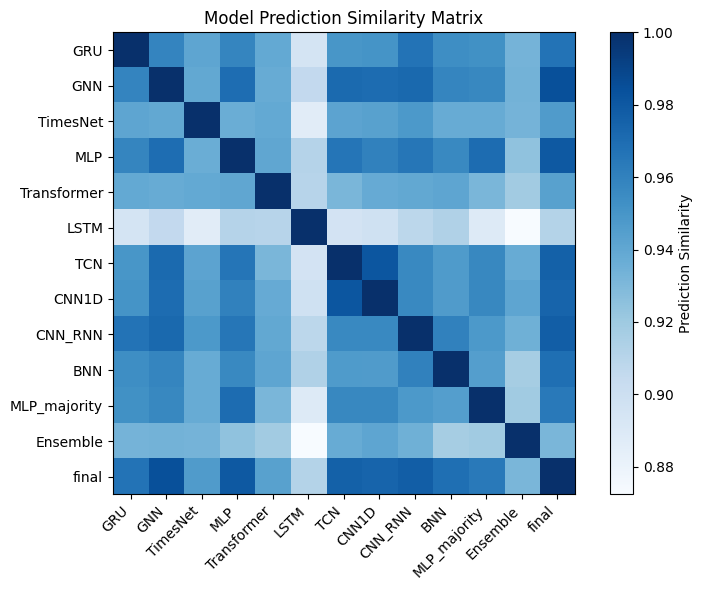

,GRU,GNN,TimesNet,MLP,Transformer,LSTM,TCN,CNN1D,CNN_RNN,BNN,MLP_majority,Ensemble,final
GRU,1.00,0.96,0.94,0.96,0.94,0.90,0.95,0.95,0.97,0.95,0.95,0.93,0.97
GNN,0.96,1.00,0.94,0.97,0.94,0.91,0.97,0.97,0.97,0.96,0.96,0.93,0.98
TimesNet,0.94,0.94,1.00,0.94,0.94,0.89,0.94,0.94,0.95,0.94,0.94,0.93,0.95
MLP,0.96,0.97,0.94,1.00,0.94,0.91,0.97,0.96,0.97,0.96,0.97,0.92,0.98
Transformer,0.94,0.94,0.94,0.94,1.00,0.91,0.93,0.94,0.94,0.94,0.93,0.92,0.94
LSTM,0.90,0.91,0.89,0.91,0.91,1.00,0.90,0.90,0.91,0.91,0.89,0.87,0.91
TCN,0.95,0.97,0.94,0.97,0.93,0.90,1.00,0.98,0.96,0.95,0.96,0.94,0.98
CNN1D,0.95,0.97,0.94,0.96,0.94,0.90,0.98,1.00,0.96,0.95,0.96,0.94,0.97
CNN_RNN,0.97,0.97,0.95,0.97,0.94,0.91,0.96,0.96,1.00,0.96,0.95,0.94,0.98
BNN,0.95,0.96,0.94,0.96,0.94,0.91,0.95,0.95,0.96,1.00,0.94,0.92,0.97


In [3]:
# --------------------------
# MODEL PREDICTION SIMILARITY ANALYSIS
# --------------------------

pred_dir = "prediction"
files = [f for f in os.listdir(pred_dir) if f.endswith(".csv")]
preds = {}

for file in files:
    model_name = file.replace("submission_", "").replace(".csv", "")
    df = pd.read_csv(os.path.join(pred_dir, file))
    preds[model_name] = df["label"].values

pred_df = pd.DataFrame(preds)
models = list(pred_df.columns)
n = len(models)
similarity_matrix = pd.DataFrame(0.0, index=models, columns=models)

for i in range(n):
    for j in range(n):
        same = (pred_df[models[i]] == pred_df[models[j]]).mean()
        similarity_matrix.iloc[i, j] = same

plt.figure(figsize=(8,6))
plt.imshow(similarity_matrix, cmap="Blues", interpolation="nearest")
plt.colorbar(label="Prediction Similarity")
plt.xticks(range(n), models, rotation=45, ha="right")
plt.yticks(range(n), models)
plt.title("Model Prediction Similarity Matrix")
plt.tight_layout()
plt.savefig(os.path.join(PLOTS_DIR, f'model_prediction_similarity_{timestamp}.png'))
plt.show()

display(similarity_matrix.round(2))


In [4]:
# --------------------------
# MAJORITY-VOTE PREDICTION
# --------------------------

from collections import Counter

pred_dir = "prediction"
output_file = os.path.join(pred_dir, "submission_final.csv")

model_weights = {
    "BNN": 1.0,
    "CNN1D": 1.0,
    "CNN_RNN": 1.0,
    "Ensemble": 0.0,
    "GNN": 1.0,
    "GRU": 1.0,
    "LSTM": 1.0,
    "MLP": 1.0,
    "TCN": 1.0,
    "TimesNet": 0.0,
    "Transformer": 0.0  
}

files = [f for f in os.listdir(pred_dir) if f.endswith(".csv")]
preds = {}
for file in files:
    model_name = file.replace("submission_", "").replace(".csv", "")
    df = pd.read_csv(os.path.join(pred_dir, file))
    preds[model_name] = df["label"].values

pred_df = pd.DataFrame(preds)
sample_index = pd.read_csv(os.path.join(pred_dir, files[0]))["sample_index"]

final_preds = []
for i in range(len(pred_df)):
    votes = Counter()
    for model_name, label in pred_df.iloc[i].items():
        w = model_weights.get(model_name, 1.0)
        votes[label] += w
    final_label = votes.most_common(1)[0][0]
    final_preds.append(final_label)

final_df = pd.DataFrame({
    "sample_index": sample_index,
    "label": final_preds
})

final_df.to_csv(output_file, index=False)
print(f"Majority-vote prediction saved to: {output_file}")
display(final_df.head())


Majority-vote prediction saved to: prediction/submission_final.csv


,sample_index,label
0,0,no_pain
1,1,no_pain
2,2,no_pain
3,3,no_pain
4,4,no_pain
